# 🎯 Multilingual Classification Comparison: Imbalanced vs Random Oversampling vs Synthetic Augmentation

## Objective
Compare classification performance across three data augmentation strategies for multilingual fake news detection:

1. **Original Imbalanced Data** - Train on raw imbalanced dataset (baseline)
2. **Random Oversampling** - Train on randomly oversampled minority class from original data
3. **Synthetic Augmentation** - Train on data augmented with our GPT-4 generated synthetic articles

## Dataset
- **Source**: TALLIP Celebrity domain dataset
- **Languages**: Vietnamese, English, Hindi, Swahili, Indonesian
- **Classes**: Fake (0) vs Legitimate (1)
- **Challenge**: Class imbalance varies across languages (~20% imbalance)

## Methodology
- **Models**: Best performing algorithm from previous experiments
- **Features**: Stylistic features (16 language-agnostic characteristics)
- **Evaluation**: Per-language and overall metrics (Accuracy, Precision, Recall, F1, ROC-AUC)
- **Test Set**: Held-out 20% stratified by language and class

## Expected Outcome
Validate that synthetic articles improve F1 scores for fake news detection, especially for minority class.

## 1. Setup and Imports

In [2]:
# Core Libraries
import pandas as pd
import numpy as np
import json
from pathlib import Path
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning - Models
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

# Machine Learning - Preprocessing & Validation
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

# Machine Learning - Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, auc
)

# Display Settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 100)

# Plot Settings
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)

print("✅ All libraries imported successfully")
print(f"📅 Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ All libraries imported successfully
📅 Analysis Date: 2025-12-07 16:24:40


## 2. Load Original Multilingual Dataset (Celebrity Domain, Top 5 Languages)

In [13]:
# Load original TALLIP Celebrity domain dataset with top 5 languages
# This is the SAME filtered dataset used in multilingual_dataset_analysis.ipynb
print("="*80)
print("📥 LOADING CELEBRITY DOMAIN DATASET (TOP 5 LANGUAGES)")
print("="*80)

data_dir = Path('/home/mateja/Documents/IJS/current/Fairer_Models/data/processed')
dataset_file = data_dir / 'multilingual_dataset_analyzed.csv'

if dataset_file.exists():
    # Load full dataset
    # Use quoting parameter to handle commas within quoted fields
    df_all = pd.read_csv(dataset_file, quoting=1, on_bad_lines='skip')  # quoting=1 is csv.QUOTE_ALL
    print(f"✅ Loaded full dataset: {len(df_all):,} articles")
    
    # Filter for Celebrity domain and top 5 languages
    # This matches the filtering done in multilingual_dataset_analysis.ipynb Section 12.1
    top_5_languages = ['vi', 'sw', 'en', 'hi', 'id']  # Vietnamese, Swahili, English, Hindi, Indonesian
    
    original_df = df_all[
        (df_all['Domain'] == 'Celebrity') & 
        (df_all['language'].isin(top_5_languages))
    ].copy()
    
    print(f"✅ Filtered to Celebrity domain + Top 5 languages: {len(original_df):,} articles")
    
    # Display domain verification
    print(f"\n📁 Domain Distribution:")
    domain_counts = original_df['Domain'].value_counts()
    for domain, count in domain_counts.items():
        print(f"   {domain}: {count:,} articles")
    
    # Language distribution
    # Expected counts from multilingual_dataset_analysis.ipynb:
    # vi: 1,012 (Fake: 496, Legit: 516)
    # English: 992 (Fake: 498, Legit: 494)
    # Hindi: 990 (Fake: 498, Legit: 492)
    # sw: 984 (Fake: 496, Legit: 488)
    # Indonesian: 978 (Fake: 488, Legit: 490)
    # Total: 4,956 articles (Fake: 2,476, Legit: 2,480)
    
    print(f"\n🌍 Language Distribution (Top 5):")
    lang_names = {
        'vi': 'Vietnamese',
        'en': 'English', 
        'hi': 'Hindi',
        'sw': 'Swahili',
        'id': 'Indonesian'
    }
    
    for lang in top_5_languages:
        lang_data = original_df[original_df['language'] == lang]
        lang_name = lang_names.get(lang, lang)
        percentage = (len(lang_data) / len(original_df)) * 100
        print(f"   {lang_name:15s} ({lang}): {len(lang_data):,} articles ({percentage:.1f}%)")
    
    # Class distribution overall
    print(f"\n📊 Overall Class Distribution:")
    class_dist = original_df['Label'].value_counts()
    # Handle both string labels ("Fake", "Legit") and numeric (0, 1)
    for label_str, label_num in [('Fake', 0), ('Legit', 1)]:
        # Try both string and numeric matching
        count = len(original_df[(original_df['Label'] == label_str) | (original_df['Label'] == label_num)])
        label_name = 'Legitimate' if label_num == 1 else 'Fake'
        percentage = (count / len(original_df)) * 100
        print(f"   {label_name} ({label_num}): {count:,} articles ({percentage:.1f}%)")
    
    # Verify expected totals
    expected_total = 4956  # From analysis notebook
    expected_fake = 2476
    expected_legit = 2480
    
    if len(original_df) != expected_total:
        print(f"\n⚠️  WARNING: Expected {expected_total:,} articles but got {len(original_df):,}")
    else:
        print(f"\n✅ Article count verified: {len(original_df):,} total articles")
    
    # Class distribution by language
    print(f"\n📊 Class Distribution by Language:")
    for lang in top_5_languages:
        lang_name = lang_names.get(lang, lang)
        lang_data = original_df[original_df['language'] == lang]
        # Handle both string labels ("Fake", "Legit") and numeric (0, 1)
        fake_count = len(lang_data[(lang_data['Label'] == 'Fake') | (lang_data['Label'] == 0)])
        legit_count = len(lang_data[(lang_data['Label'] == 'Legit') | (lang_data['Label'] == 1)])
        imbalance_ratio = fake_count / legit_count if legit_count > 0 else 0
        
        print(f"\n   {lang_name.upper()} ({lang}):")
        print(f"      Total: {len(lang_data):,}")
        print(f"      Fake: {fake_count:,} ({fake_count/len(lang_data)*100:.1f}%)")
        print(f"      Legit: {legit_count:,} ({legit_count/len(lang_data)*100:.1f}%)")
        print(f"      Imbalance ratio (Fake/Legit): {imbalance_ratio:.3f}")
    
    # Show sample articles
    print(f"\n📝 Sample Articles:")
    for lang in top_5_languages[:3]:  # Show samples from first 3 languages
        lang_name = lang_names.get(lang, lang)
        sample = original_df[original_df['language'] == lang].iloc[0]
        # Handle both string and numeric labels
        label_name = 'LEGIT' if sample['Label'] in ['Legit', 'Legitimate', 1] else 'FAKE'
        preview = str(sample['News'])[:80] + "..." if len(str(sample['News'])) > 80 else str(sample['News'])
        print(f"   [{lang_name}] [{label_name}] {preview}")
            
else:
    print(f"❌ Dataset file not found: {dataset_file}")
    original_df = None

print("\n" + "="*80)

📥 LOADING CELEBRITY DOMAIN DATASET (TOP 5 LANGUAGES)
✅ Loaded full dataset: 9,800 articles
✅ Filtered to Celebrity domain + Top 5 languages: 4,956 articles

📁 Domain Distribution:
   Celebrity: 4,956 articles

🌍 Language Distribution (Top 5):
   Vietnamese      (vi): 1,012 articles (20.4%)
   Swahili         (sw): 984 articles (19.9%)
   English         (en): 992 articles (20.0%)
   Hindi           (hi): 990 articles (20.0%)
   Indonesian      (id): 978 articles (19.7%)

📊 Overall Class Distribution:
   Fake (0): 2,476 articles (50.0%)
   Legitimate (1): 2,480 articles (50.0%)

✅ Article count verified: 4,956 total articles

📊 Class Distribution by Language:

   VIETNAMESE (vi):
      Total: 1,012
      Fake: 496 (49.0%)
      Legit: 516 (51.0%)
      Imbalance ratio (Fake/Legit): 0.961

   SWAHILI (sw):
      Total: 984
      Fake: 496 (50.4%)
      Legit: 488 (49.6%)
      Imbalance ratio (Fake/Legit): 1.016

   ENGLISH (en):
      Total: 992
      Fake: 498 (50.2%)
      Legit: 494 

## 3. Load Synthetic Articles

In [14]:
# Load synthetic articles generated by GPT-4
print("="*80)
print("📥 LOADING SYNTHETIC ARTICLES")
print("="*80)

synthetic_dir = Path('/home/mateja/Documents/IJS/current/Fairer_Models/data/synthetic')

# Find the most recent synthetic articles file
# These were generated for the same 5 languages: vi, sw, en, hi, id
synthetic_files = list(synthetic_dir.glob('synthetic_articles_2025*.csv'))
synthetic_files.sort(key=lambda x: x.stat().st_mtime, reverse=True)

if synthetic_files:
    synthetic_file = synthetic_files[0]  # Most recent
    print(f"📁 Loading: {synthetic_file.name}")
    
    synthetic_df = pd.read_csv(synthetic_file)
    print(f"✅ Loaded: {len(synthetic_df):,} synthetic articles")
    
    # Map language codes to names for consistency
    lang_code_map = {
        'vietnamese': 'vi',
        'english': 'en',
        'hindi': 'hi',
        'swahili': 'sw',
        'indonesian': 'id'
    }
    
    # Standardize language codes
    if 'language' in synthetic_df.columns:
        synthetic_df['language'] = synthetic_df['language'].str.lower()
        synthetic_df['language'] = synthetic_df['language'].map(lang_code_map).fillna(synthetic_df['language'])
    
    # Display info
    print(f"\n📊 Synthetic Dataset Overview:")
    print(f"   Columns: {list(synthetic_df.columns)}")
    print(f"   Shape: {synthetic_df.shape}")
    
    # Language distribution
    lang_names = {
        'vi': 'Vietnamese',
        'en': 'English',
        'hi': 'Hindi',
        'sw': 'Swahili',
        'id': 'Indonesian'
    }
    
    if 'language' in synthetic_df.columns:
        print(f"\n🌍 Language Distribution:")
        for lang_code in ['vi', 'en', 'hi', 'sw', 'id']:
            count = len(synthetic_df[synthetic_df['language'] == lang_code])
            lang_name = lang_names.get(lang_code, lang_code)
            if count > 0:
                print(f"   {lang_name:15s} ({lang_code}): {count:,} articles")
    
    # Quality metrics
    if 'compliance_rate' in synthetic_df.columns:
        print(f"\n📈 Quality Metrics:")
        print(f"   Avg Compliance Rate: {synthetic_df['compliance_rate'].mean():.1%}")
        print(f"   Min Compliance: {synthetic_df['compliance_rate'].min():.1%}")
        print(f"   Max Compliance: {synthetic_df['compliance_rate'].max():.1%}")
        print(f"   Median Compliance: {synthetic_df['compliance_rate'].median():.1%}")
    
    # Article length statistics
    if 'feature_char_count' in synthetic_df.columns:
        print(f"\n📏 Article Length:")
        print(f"   Avg Characters: {synthetic_df['feature_char_count'].mean():.0f}")
        print(f"   Avg Words: {synthetic_df['feature_word_count'].mean():.0f}")
    
    # Show sample
    print(f"\n📝 Sample Synthetic Articles:")
    for idx, row in synthetic_df.head(3).iterrows():
        lang = row['language']
        article_preview = str(row['article'])[:80] + "..." if len(str(row['article'])) > 80 else str(row['article'])
        compliance = row.get('compliance_rate', 0)
        print(f"   [{lang}] (compliance: {compliance:.1%}) {article_preview}")
    
else:
    print("❌ No synthetic articles found in:", synthetic_dir)
    synthetic_df = None

print("\n" + "="*80)

📥 LOADING SYNTHETIC ARTICLES
📁 Loading: synthetic_articles_20251130_211351.csv
✅ Loaded: 500 synthetic articles

📊 Synthetic Dataset Overview:
   Columns: ['language', 'topic', 'article', 'model', 'temperature', 'timestamp', 'compliance_rate', 'features_in_range', 'features_checked', 'feature_char_count', 'feature_word_count', 'feature_sentence_count', 'feature_avg_word_length', 'feature_avg_sentence_length', 'feature_punctuation_ratio', 'feature_uppercase_ratio', 'feature_digit_ratio', 'feature_special_char_ratio', 'feature_unique_word_ratio', 'feature_short_word_ratio', 'feature_long_word_ratio', 'feature_lexical_diversity', 'feature_exclamation_ratio', 'feature_question_ratio', 'feature_quote_ratio']
   Shape: (500, 25)

🌍 Language Distribution:
   Vietnamese      (vi): 100 articles
   English         (en): 100 articles
   Hindi           (hi): 100 articles
   Swahili         (sw): 100 articles
   Indonesian      (id): 100 articles

📈 Quality Metrics:
   Avg Compliance Rate: 17.5%
 

## 4. Data Preparation Summary

In [15]:
# Summary of loaded data
print("="*80)
print("📋 DATA LOADING SUMMARY")
print("="*80)

summary = {
    'Original Dataset': {
        'Status': '✅ Loaded' if original_df is not None else '❌ Not Found',
        'Articles': len(original_df) if original_df is not None else 0,
        'Languages': len(original_df['language'].unique()) if original_df is not None else 0,
        'File': str(dataset_file)
    },
    'Synthetic Dataset': {
        'Status': '✅ Loaded' if synthetic_df is not None else '❌ Not Found',
        'Articles': len(synthetic_df) if synthetic_df is not None else 0,
        'Languages': len(synthetic_df['language'].unique()) if synthetic_df is not None else 0,
        'File': str(synthetic_file) if synthetic_files else 'N/A'
    }
}

for dataset_name, details in summary.items():
    print(f"\n{dataset_name}:")
    for key, value in details.items():
        print(f"   {key}: {value}")

# Check readiness for experiments
print("\n" + "="*80)
if original_df is not None:
    print("✅ READY FOR CLASSIFICATION EXPERIMENTS")
    print("\n📋 Next Steps:")
    print("   1. Prepare three dataset variants:")
    print("      - Variant 1: Original imbalanced data")
    print("      - Variant 2: Random oversampling of original data")
    print("      - Variant 3: Original + synthetic augmentation")
    print("   2. Extract stylistic features (16 language-agnostic)")
    print("   3. Train classifiers on each variant")
    print("   4. Compare performance metrics by language and overall")
else:
    print("⚠️  CANNOT PROCEED - Original dataset not loaded")
    
print("="*80)

📋 DATA LOADING SUMMARY

Original Dataset:
   Status: ✅ Loaded
   Articles: 4956
   Languages: 5
   File: /home/mateja/Documents/IJS/current/Fairer_Models/data/processed/multilingual_dataset_analyzed.csv

Synthetic Dataset:
   Status: ✅ Loaded
   Articles: 500
   Languages: 5
   File: /home/mateja/Documents/IJS/current/Fairer_Models/data/synthetic/synthetic_articles_20251130_211351.csv

✅ READY FOR CLASSIFICATION EXPERIMENTS

📋 Next Steps:
   1. Prepare three dataset variants:
      - Variant 1: Original imbalanced data
      - Variant 2: Random oversampling of original data
      - Variant 3: Original + synthetic augmentation
   2. Extract stylistic features (16 language-agnostic)
   3. Train classifiers on each variant
   4. Compare performance metrics by language and overall


## 5. Prepare Three Dataset Variants

In [16]:
# Prepare three variants for comparison
print("="*80)
print("🔄 PREPARING DATASET VARIANTS")
print("="*80)

# Ensure we have the data
if original_df is None:
    raise ValueError("Original dataset not loaded. Cannot proceed.")

# Debug: Check what columns and values we have
print("\n🔍 DEBUG: Data structure check")
print(f"   Columns in original_df: {list(original_df.columns)}")
print(f"   Shape: {original_df.shape}")
print(f"   Label column unique values: {original_df['Label'].unique()}")
print(f"   Label value counts:\n{original_df['Label'].value_counts()}")

# Standardize column names for processing
original_df_processed = original_df.copy()
original_df_processed['text'] = original_df_processed['News']

# Convert Label to numeric (0 for Fake, 1 for Legit)
# Handle different possible label formats
if original_df_processed['Label'].dtype == 'object':
    label_map = {
        'Fake': 0,
        'fake': 0,
        'Legit': 1,
        'legit': 1,
        'Legitimate': 1,
        'legitimate': 1,
        0: 0,
        1: 1,
        '0': 0,
        '1': 1
    }
    original_df_processed['label'] = original_df_processed['Label'].map(label_map)
    
    # Check for unmapped values
    unmapped = original_df_processed[original_df_processed['label'].isna()]
    if len(unmapped) > 0:
        print(f"\n⚠️  Warning: {len(unmapped)} rows with unmapped Label values:")
        print(f"   Unmapped values: {unmapped['Label'].unique()}")
        # Drop unmapped rows
        original_df_processed = original_df_processed.dropna(subset=['label'])
else:
    original_df_processed['label'] = original_df_processed['Label'].astype(int)

print(f"\n✅ After label conversion:")
print(f"   Total rows: {len(original_df_processed):,}")
print(f"   Label distribution:\n{original_df_processed['label'].value_counts()}")

# =============================================================================
# STEP 1: Remove 100 fake articles per language (to be replaced by synthetic)
# =============================================================================
print("\n📊 STEP 1: Creating Base Dataset (Remove 100 fake articles per language)")
print("-" * 80)

# Separate legitimate and fake articles
legit_articles = original_df_processed[original_df_processed['label'] == 1].copy()
fake_articles = original_df_processed[original_df_processed['label'] == 0].copy()

print(f"   Original dataset:")
print(f"      Legitimate: {len(legit_articles):,}")
print(f"      Fake: {len(fake_articles):,}")

# Remove 100 fake articles from each language
removed_fake_articles = []
remaining_fake_articles = []

top_5_languages = ['vi', 'en', 'hi', 'sw', 'id']

for lang in top_5_languages:
    lang_fake = fake_articles[fake_articles['language'] == lang].copy()
    
    # Randomly sample 100 articles to remove (these will be replaced by synthetic)
    if len(lang_fake) >= 100:
        removed = lang_fake.sample(n=100, random_state=42)
        remaining = lang_fake.drop(removed.index)
    else:
        print(f"   ⚠️  Warning: {lang} has only {len(lang_fake)} fake articles (< 100)")
        removed = lang_fake.sample(frac=1, random_state=42)  # Take all available
        remaining = pd.DataFrame()
    
    removed_fake_articles.append(removed)
    remaining_fake_articles.append(remaining)
    
    print(f"   {lang}: Removed {len(removed):,} fake articles, Kept {len(remaining):,}")

# Combine
removed_fake_df = pd.concat(removed_fake_articles, ignore_index=True)
remaining_fake_df = pd.concat(remaining_fake_articles, ignore_index=True)

print(f"\n   Total removed: {len(removed_fake_df):,} fake articles (held out for synthetic replacement)")
print(f"   Total remaining: {len(remaining_fake_df):,} fake articles")

# =============================================================================
# VARIANT 1: Original Imbalanced Data (with 100 fake articles removed per language)
# =============================================================================
print("\n📊 VARIANT 1: Original Imbalanced Data (Base Dataset)")
variant1_df = pd.concat([legit_articles, remaining_fake_df], ignore_index=True)
variant1_df = variant1_df[['text', 'label', 'language']].copy()
variant1_df['source'] = 'original'
variant1_df = variant1_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"   Total articles: {len(variant1_df):,}")
print(f"   Legitimate (1): {len(variant1_df[variant1_df['label'] == 1]):,}")
print(f"   Fake (0): {len(variant1_df[variant1_df['label'] == 0]):,}")

legit_count_v1 = len(variant1_df[variant1_df['label'] == 1])
fake_count_v1 = len(variant1_df[variant1_df['label'] == 0])
if legit_count_v1 > 0:
    imbalance_ratio = fake_count_v1 / legit_count_v1
    print(f"   Imbalance ratio (Fake/Legit): {imbalance_ratio:.3f}")
else:
    print(f"   ⚠️  Warning: No legitimate articles found!")

# Per-language breakdown
print("\n   Per-language breakdown:")
for lang in top_5_languages:
    lang_data = variant1_df[variant1_df['language'] == lang]
    fake_count = len(lang_data[lang_data['label'] == 0])
    legit_count = len(lang_data[lang_data['label'] == 1])
    lang_ratio = fake_count / legit_count if legit_count > 0 else 0
    print(f"      {lang}: Fake={fake_count:,}, Legit={legit_count:,}, Ratio={lang_ratio:.3f}")

# =============================================================================
# VARIANT 2: Random Oversampling (oversample the reduced dataset)
# =============================================================================
print("\n📊 VARIANT 2: Random Oversampling")

# Use variant1_df (already has reduced fake articles)
legit_v2 = variant1_df[variant1_df['label'] == 1].copy()
fake_v2 = variant1_df[variant1_df['label'] == 0].copy()

print(f"   Base dataset (from Variant 1):")
print(f"      Legitimate: {len(legit_v2):,}")
print(f"      Fake: {len(fake_v2):,}")

# Determine target size (match majority class)
target_size = max(len(legit_v2), len(fake_v2))

# Oversample minority class to match majority
if len(fake_v2) < target_size:
    # Random oversampling with replacement
    additional_samples_needed = target_size - len(fake_v2)
    fake_oversampled_additional = fake_v2.sample(n=additional_samples_needed, replace=True, random_state=42)
    fake_oversampled_additional['source'] = 'random_oversampled'
    fake_v2['source'] = 'original'
    
    fake_combined = pd.concat([fake_v2, fake_oversampled_additional], ignore_index=True)
    print(f"\n   Random oversampling: {len(fake_v2):,} → {len(fake_combined):,} (+{additional_samples_needed:,})")
else:
    fake_combined = fake_v2
    fake_combined['source'] = 'original'

# Combine
legit_v2['source'] = 'original'
variant2_df = pd.concat([legit_v2, fake_combined], ignore_index=True)
variant2_df = variant2_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"\n   After random oversampling:")
print(f"      Total articles: {len(variant2_df):,}")
print(f"      Legitimate (1): {len(variant2_df[variant2_df['label'] == 1]):,}")
print(f"      Fake (0): {len(variant2_df[variant2_df['label'] == 0]):,}")

legit_count_v2 = len(variant2_df[variant2_df['label'] == 1])
fake_count_v2 = len(variant2_df[variant2_df['label'] == 0])
if legit_count_v2 > 0:
    balance_ratio = fake_count_v2 / legit_count_v2
    print(f"      Balance ratio: {balance_ratio:.3f}")
else:
    print(f"      ⚠️  Warning: No legitimate articles found!")

# Source breakdown
print("\n   Source breakdown:")
source_breakdown_v2 = variant2_df.groupby(['label', 'source']).size().unstack(fill_value=0)
print(source_breakdown_v2)

# =============================================================================
# VARIANT 3: Synthetic Augmentation (add 100 synthetic articles per language)
# =============================================================================
print("\n📊 VARIANT 3: Synthetic Augmentation")

if synthetic_df is not None:
    # Prepare synthetic data to match format
    synthetic_processed = synthetic_df.copy()
    synthetic_processed['text'] = synthetic_processed['article']
    synthetic_processed['label'] = 0  # All synthetic are fake
    synthetic_processed['source'] = 'synthetic'
    
    # Select 100 synthetic articles per language (matching what we removed)
    synthetic_to_add = []
    
    print(f"   Selecting 100 synthetic articles per language:")
    for lang in top_5_languages:
        lang_synthetic = synthetic_processed[synthetic_processed['language'] == lang].copy()
        
        if len(lang_synthetic) >= 100:
            selected = lang_synthetic.sample(n=100, random_state=42)
            print(f"      {lang}: Selected 100 from {len(lang_synthetic):,} available")
        else:
            selected = lang_synthetic.sample(frac=1, random_state=42)
            print(f"      {lang}: ⚠️  Only {len(selected):,} available (< 100)")
        
        synthetic_to_add.append(selected)
    
    synthetic_for_training = pd.concat(synthetic_to_add, ignore_index=True)
    synthetic_for_training = synthetic_for_training[['text', 'label', 'language', 'source']].copy()
    
    print(f"\n   Base dataset (Variant 1): {len(variant1_df):,} articles")
    print(f"   Synthetic to add: {len(synthetic_for_training):,} articles")
    
    # Combine base dataset + synthetic articles
    variant3_df = pd.concat([variant1_df, synthetic_for_training], ignore_index=True)
    variant3_df = variant3_df.sample(frac=1, random_state=42).reset_index(drop=True)
    
    print(f"\n   After synthetic augmentation:")
    print(f"      Total articles: {len(variant3_df):,}")
    print(f"      Legitimate (1): {len(variant3_df[variant3_df['label'] == 1]):,}")
    print(f"      Fake (0): {len(variant3_df[variant3_df['label'] == 0]):,}")
    
    legit_count_v3 = len(variant3_df[variant3_df['label'] == 1])
    fake_count_v3 = len(variant3_df[variant3_df['label'] == 0])
    if legit_count_v3 > 0:
        augmented_ratio = fake_count_v3 / legit_count_v3
        print(f"      Augmented ratio: {augmented_ratio:.3f}")
    else:
        print(f"      ⚠️  Warning: No legitimate articles found!")
    
    # Source breakdown
    print("\n   Source breakdown:")
    source_breakdown = variant3_df.groupby(['label', 'source']).size().unstack(fill_value=0)
    print(source_breakdown)
    
    # Per-language breakdown
    print("\n   Per-language comparison:")
    print(f"      {'Language':<12} {'Original Fake':<15} {'Synthetic':<12} {'Total Fake':<12}")
    print(f"      {'-'*12} {'-'*15} {'-'*12} {'-'*12}")
    for lang in top_5_languages:
        lang_data = variant3_df[variant3_df['language'] == lang]
        lang_data_v1 = variant1_df[variant1_df['language'] == lang]
        
        original_fake = len(lang_data_v1[lang_data_v1['label'] == 0])
        synthetic_count = len(lang_data[(lang_data['source'] == 'synthetic') & (lang_data['label'] == 0)])
        total_fake = len(lang_data[lang_data['label'] == 0])
        
        print(f"      {lang:<12} {original_fake:<15} {synthetic_count:<12} {total_fake:<12}")
    
else:
    print("   ❌ Synthetic data not available - skipping variant 3")
    variant3_df = None

print("\n" + "="*80)
print("✅ All dataset variants prepared successfully")
print("="*80)


🔄 PREPARING DATASET VARIANTS

🔍 DEBUG: Data structure check
   Columns in original_df: ['Domain', 'Topic', 'News', 'Label', 'source_file', 'split', 'language', 'language_name', 'text_length', 'word_count', 'topic_length']
   Shape: (4956, 11)
   Label column unique values: ['Legit' 'Fake']
   Label value counts:
Label
Legit    2480
Fake     2476
Name: count, dtype: int64

✅ After label conversion:
   Total rows: 4,956
   Label distribution:
label
1    2480
0    2476
Name: count, dtype: int64

📊 STEP 1: Creating Base Dataset (Remove 100 fake articles per language)
--------------------------------------------------------------------------------
   Original dataset:
      Legitimate: 2,480
      Fake: 2,476
   vi: Removed 100 fake articles, Kept 396
   en: Removed 100 fake articles, Kept 398
   hi: Removed 100 fake articles, Kept 398
   sw: Removed 100 fake articles, Kept 396
   id: Removed 100 fake articles, Kept 388

   Total removed: 500 fake articles (held out for synthetic replacemen

## 6. TF-IDF Vectorization Configuration

In [17]:
# Configure TF-IDF vectorizer
print("="*80)
print("⚙️  TF-IDF VECTORIZER CONFIGURATION")
print("="*80)

# TF-IDF parameters (optimized for multilingual fake news detection)
tfidf_params = {
    'max_features': 5000,        # Limit to top 5000 features
    'min_df': 2,                 # Ignore terms that appear in fewer than 2 documents
    'max_df': 0.95,              # Ignore terms that appear in more than 95% of documents
    'ngram_range': (1, 2),       # Use unigrams and bigrams
    'sublinear_tf': True,        # Apply sublinear tf scaling
    'strip_accents': None,       # Preserve accents for multilingual text
    'lowercase': True,           # Convert to lowercase
    'analyzer': 'word',          # Word-level analysis
    'token_pattern': r'\b\w+\b'  # Match word boundaries
}

print("\n📋 TF-IDF Parameters:")
for param, value in tfidf_params.items():
    print(f"   {param}: {value}")

print("\n✅ Configuration complete")
print("="*80)

⚙️  TF-IDF VECTORIZER CONFIGURATION

📋 TF-IDF Parameters:
   max_features: 5000
   min_df: 2
   max_df: 0.95
   ngram_range: (1, 2)
   sublinear_tf: True
   strip_accents: None
   lowercase: True
   analyzer: word
   token_pattern: \b\w+\b

✅ Configuration complete


## 7. Prepare Text Data for Vectorization

In [18]:
# Function to prepare text data
def prepare_text_data(df):
    """Extract text and labels from dataframe"""
    texts = df['text'].fillna('').astype(str).values
    labels = df['label'].values
    languages = df['language'].values if 'language' in df.columns else None
    return texts, labels, languages

print("="*80)
print("🔄 PREPARING TEXT DATA")
print("="*80)

# Prepare text for Variant 1
print("\n📊 Variant 1: Original Imbalanced Data")
texts1, y1, lang1 = prepare_text_data(variant1_df)
print(f"   Articles: {len(texts1):,}")
print(f"   Sample text length: {len(texts1[0])} chars")

# Prepare text for Variant 2
print("\n📊 Variant 2: Random Oversampling")
texts2, y2, lang2 = prepare_text_data(variant2_df)
print(f"   Articles: {len(texts2):,}")

# Prepare text for Variant 3 (if available)
if variant3_df is not None:
    print("\n📊 Variant 3: Synthetic Augmentation")
    texts3, y3, lang3 = prepare_text_data(variant3_df)
    print(f"   Articles: {len(texts3):,}")
else:
    texts3, y3, lang3 = None, None, None
    print("\n⚠️  Variant 3 skipped (no synthetic data)")

print("\n" + "="*80)
print("✅ Text data prepared for all variants")
print("="*80)

🔄 PREPARING TEXT DATA

📊 Variant 1: Original Imbalanced Data
   Articles: 4,456
   Sample text length: 396 chars

📊 Variant 2: Random Oversampling
   Articles: 4,960

📊 Variant 3: Synthetic Augmentation
   Articles: 4,956

✅ Text data prepared for all variants


## 8. Train-Test Split

Split each variant into training and test sets using stratified sampling.

In [19]:
# Perform stratified train-test splits
print("="*80)
print("🔄 TRAIN-TEST SPLIT")
print("="*80)

test_size = 0.2
random_state = 42

# Split Variant 1
print("\n📊 Variant 1: Original Imbalanced Data")
texts1_train, texts1_test, y1_train, y1_test, lang1_train, lang1_test = train_test_split(
    texts1, y1, lang1, test_size=test_size, random_state=random_state, stratify=y1
)
print(f"   Train: {len(texts1_train):,} | Test: {len(texts1_test):,}")
print(f"   Train - Fake: {np.sum(y1_train == 0):,}, Legit: {np.sum(y1_train == 1):,}")
print(f"   Test  - Fake: {np.sum(y1_test == 0):,}, Legit: {np.sum(y1_test == 1):,}")

# Split Variant 2
print("\n📊 Variant 2: Random Oversampling")
texts2_train, texts2_test, y2_train, y2_test, lang2_train, lang2_test = train_test_split(
    texts2, y2, lang2, test_size=test_size, random_state=random_state, stratify=y2
)
print(f"   Train: {len(texts2_train):,} | Test: {len(texts2_test):,}")
print(f"   Train - Fake: {np.sum(y2_train == 0):,}, Legit: {np.sum(y2_train == 1):,}")
print(f"   Test  - Fake: {np.sum(y2_test == 0):,}, Legit: {np.sum(y2_test == 1):,}")

# Split Variant 3 (if available)
if texts3 is not None:
    print("\n📊 Variant 3: Synthetic Augmentation")
    texts3_train, texts3_test, y3_train, y3_test, lang3_train, lang3_test = train_test_split(
        texts3, y3, lang3, test_size=test_size, random_state=random_state, stratify=y3
    )
    print(f"   Train: {len(texts3_train):,} | Test: {len(texts3_test):,}")
    print(f"   Train - Fake: {np.sum(y3_train == 0):,}, Legit: {np.sum(y3_train == 1):,}")
    print(f"   Test  - Fake: {np.sum(y3_test == 0):,}, Legit: {np.sum(y3_test == 1):,}")
else:
    texts3_train, texts3_test = None, None
    y3_train, y3_test = None, None
    lang3_train, lang3_test = None, None

print("\n" + "="*80)
print("✅ Train-test splits completed")
print("="*80)

🔄 TRAIN-TEST SPLIT

📊 Variant 1: Original Imbalanced Data
   Train: 3,564 | Test: 892
   Train - Fake: 1,580, Legit: 1,984
   Test  - Fake: 396, Legit: 496

📊 Variant 2: Random Oversampling
   Train: 3,968 | Test: 992
   Train - Fake: 1,984, Legit: 1,984
   Test  - Fake: 496, Legit: 496

📊 Variant 3: Synthetic Augmentation
   Train: 3,964 | Test: 992
   Train - Fake: 1,980, Legit: 1,984
   Test  - Fake: 496, Legit: 496

✅ Train-test splits completed


## 9. TF-IDF Vectorization

Fit TF-IDF vectorizer on training data and transform both training and test sets for each variant.

In [29]:
# Vectorize all variants
print("="*80)
print("🔄 TF-IDF VECTORIZATION")
print("="*80)

# Variant 1: Original Imbalanced
print("\n📊 Variant 1: Original Imbalanced Data")
vectorizer1 = TfidfVectorizer(**tfidf_params)
X1_train = vectorizer1.fit_transform(texts1_train)
X1_test = vectorizer1.transform(texts1_test)
print(f"   Vocabulary size: {len(vectorizer1.vocabulary_):,} terms")
print(f"   Train shape: {X1_train.shape}")
print(f"   Test shape: {X1_test.shape}")
print(f"   Sparsity: {(1.0 - X1_train.nnz / (X1_train.shape[0] * X1_train.shape[1])):.2%}")

# Variant 2: Random Oversampling
print("\n📊 Variant 2: Random Oversampling")
vectorizer2 = TfidfVectorizer(**tfidf_params)
X2_train = vectorizer2.fit_transform(texts2_train)
X2_test = vectorizer2.transform(texts2_test)
print(f"   Vocabulary size: {len(vectorizer2.vocabulary_):,} terms")
print(f"   Train shape: {X2_train.shape}")
print(f"   Test shape: {X2_test.shape}")
print(f"   Sparsity: {(1.0 - X2_train.nnz / (X2_train.shape[0] * X2_train.shape[1])):.2%}")

# Variant 3: Synthetic Augmentation (if available)
if texts3_train is not None:
    print("\n📊 Variant 3: Synthetic Augmentation")
    vectorizer3 = TfidfVectorizer(**tfidf_params)
    X3_train = vectorizer3.fit_transform(texts3_train)
    X3_test = vectorizer3.transform(texts3_test)
    print(f"   Vocabulary size: {len(vectorizer3.vocabulary_):,} terms")
    print(f"   Train shape: {X3_train.shape}")
    print(f"   Test shape: {X3_test.shape}")
    print(f"   Sparsity: {(1.0 - X3_train.nnz / (X3_train.shape[0] * X3_train.shape[1])):.2%}")
else:
    X3_train, X3_test = None, None
    vectorizer3 = None
    print("\n⚠️  Variant 3 skipped (no synthetic data)")

print("\n" + "="*80)
print("✅ TF-IDF vectorization complete for all variants")
print("="*80)

🔄 TF-IDF VECTORIZATION

📊 Variant 1: Original Imbalanced Data
   Vocabulary size: 5,000 terms
   Train shape: (3564, 5000)
   Test shape: (892, 5000)
   Sparsity: 99.13%

📊 Variant 2: Random Oversampling
   Vocabulary size: 5,000 terms
   Train shape: (3564, 5000)
   Test shape: (892, 5000)
   Sparsity: 99.13%

📊 Variant 2: Random Oversampling
   Vocabulary size: 5,000 terms
   Train shape: (3968, 5000)
   Test shape: (992, 5000)
   Sparsity: 99.11%

📊 Variant 3: Synthetic Augmentation
   Vocabulary size: 5,000 terms
   Train shape: (3968, 5000)
   Test shape: (992, 5000)
   Sparsity: 99.11%

📊 Variant 3: Synthetic Augmentation
   Vocabulary size: 5,000 terms
   Train shape: (3964, 5000)
   Test shape: (992, 5000)
   Sparsity: 99.06%

✅ TF-IDF vectorization complete for all variants
   Vocabulary size: 5,000 terms
   Train shape: (3964, 5000)
   Test shape: (992, 5000)
   Sparsity: 99.06%

✅ TF-IDF vectorization complete for all variants


## 10. Model Training and Evaluation

Train multiple classifiers on each variant and evaluate performance.

In [30]:
# Define models to test
print("="*80)
print("🤖 MODEL TRAINING - OVERALL & PER-LANGUAGE")
print("="*80)

models = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'Linear SVM': LinearSVC(max_iter=2000, random_state=42)
}

# Language names for display
lang_names = {
    'vi': 'Vietnamese',
    'en': 'English',
    'hi': 'Hindi',
    'sw': 'Swahili',
    'id': 'Indonesian'
}

# Function to train and evaluate a model
def train_and_evaluate(model, X_train, X_test, y_train, y_test, variant_name, language='Overall'):
    """Train model and compute metrics"""
    
    # Train model
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)
    
    # Probabilities (for ROC-AUC)
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, 'decision_function'):
        y_proba = model.decision_function(X_test)
    else:
        y_proba = None
    
    # Calculate metrics
    # Handle both sparse matrices and arrays for size calculation
    train_size = X_train.shape[0] if hasattr(X_train, 'shape') else len(X_train)
    test_size = X_test.shape[0] if hasattr(X_test, 'shape') else len(X_test)
    
    metrics = {
        'language': language,
        'variant': variant_name,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision_fake': precision_score(y_test, y_pred, pos_label=0, zero_division=0),
        'recall_fake': recall_score(y_test, y_pred, pos_label=0, zero_division=0),
        'f1_fake': f1_score(y_test, y_pred, pos_label=0, zero_division=0),
        'precision_legit': precision_score(y_test, y_pred, pos_label=1, zero_division=0),
        'recall_legit': recall_score(y_test, y_pred, pos_label=1, zero_division=0),
        'f1_legit': f1_score(y_test, y_pred, pos_label=1, zero_division=0),
        'train_size': train_size,
        'test_size': test_size
    }
    
    # ROC-AUC if probabilities available
    if y_proba is not None:
        try:
            metrics['roc_auc'] = roc_auc_score(y_test, y_proba)
        except:
            metrics['roc_auc'] = None
    else:
        metrics['roc_auc'] = None
    
    return metrics, model, y_pred

# Storage for all results
all_results = []

# Train models on all variants - OVERALL AND PER-LANGUAGE
print("\n🔄 Training models on all variants (Overall + Per-Language)...")
print("="*80)

for model_name, model_class in models.items():
    print(f"\n{'='*80}")
    print(f"🤖 MODEL: {model_name}")
    print(f"{'='*80}")
    
    # ==========================
    # VARIANT 1: Original Imbalanced
    # ==========================
    print("\n📊 VARIANT 1: Original Imbalanced Data")
    print("-" * 80)
    
    # Overall (all languages combined)
    print("   🌍 OVERALL (All Languages Combined)")
    model = model_class
    metrics1, trained_model1, pred1 = train_and_evaluate(
        model, X1_train, X1_test, y1_train, y1_test, 
        'Variant 1: Original Imbalanced', 'Overall'
    )
    metrics1['model'] = model_name
    all_results.append(metrics1)
    print(f"      Train: {metrics1['train_size']:,} | Test: {metrics1['test_size']:,}")
    print(f"      Accuracy: {metrics1['accuracy']:.4f} | F1 Fake: {metrics1['f1_fake']:.4f} | F1 Legit: {metrics1['f1_legit']:.4f}")
    
    # Per-language models
    print("\n   🔤 PER-LANGUAGE MODELS:")
    for lang_code in ['vi', 'en', 'hi', 'sw', 'id']:
        lang_display = lang_names.get(lang_code, lang_code)
        
        # Filter data for this language
        lang_mask_train = lang1_train == lang_code
        lang_mask_test = lang1_test == lang_code
        
        if np.sum(lang_mask_train) > 0 and np.sum(lang_mask_test) > 0:
            X1_train_lang = X1_train[lang_mask_train]
            X1_test_lang = X1_test[lang_mask_test]
            y1_train_lang = y1_train[lang_mask_train]
            y1_test_lang = y1_test[lang_mask_test]
            
            # Train language-specific model
            model_lang = model_class
            metrics1_lang, _, _ = train_and_evaluate(
                model_lang, X1_train_lang, X1_test_lang, y1_train_lang, y1_test_lang,
                'Variant 1: Original Imbalanced', lang_display
            )
            metrics1_lang['model'] = model_name
            all_results.append(metrics1_lang)
            
            print(f"      {lang_display:12s} | Train: {metrics1_lang['train_size']:3d} | Test: {metrics1_lang['test_size']:3d} | "
                  f"Acc: {metrics1_lang['accuracy']:.3f} | F1: {metrics1_lang['f1_fake']:.3f}")
    
    # ==========================
    # VARIANT 2: Random Oversampling
    # ==========================
    print("\n📊 VARIANT 2: Random Oversampling")
    print("-" * 80)
    
    # Overall
    print("   🌍 OVERALL (All Languages Combined)")
    model = model_class
    metrics2, trained_model2, pred2 = train_and_evaluate(
        model, X2_train, X2_test, y2_train, y2_test,
        'Variant 2: Random Oversampling', 'Overall'
    )
    metrics2['model'] = model_name
    all_results.append(metrics2)
    print(f"      Train: {metrics2['train_size']:,} | Test: {metrics2['test_size']:,}")
    print(f"      Accuracy: {metrics2['accuracy']:.4f} | F1 Fake: {metrics2['f1_fake']:.4f} | F1 Legit: {metrics2['f1_legit']:.4f}")
    
    # Per-language
    print("\n   🔤 PER-LANGUAGE MODELS:")
    for lang_code in ['vi', 'en', 'hi', 'sw', 'id']:
        lang_display = lang_names.get(lang_code, lang_code)
        
        lang_mask_train = lang2_train == lang_code
        lang_mask_test = lang2_test == lang_code
        
        if np.sum(lang_mask_train) > 0 and np.sum(lang_mask_test) > 0:
            X2_train_lang = X2_train[lang_mask_train]
            X2_test_lang = X2_test[lang_mask_test]
            y2_train_lang = y2_train[lang_mask_train]
            y2_test_lang = y2_test[lang_mask_test]
            
            model_lang = model_class
            metrics2_lang, _, _ = train_and_evaluate(
                model_lang, X2_train_lang, X2_test_lang, y2_train_lang, y2_test_lang,
                'Variant 2: Random Oversampling', lang_display
            )
            metrics2_lang['model'] = model_name
            all_results.append(metrics2_lang)
            
            print(f"      {lang_display:12s} | Train: {metrics2_lang['train_size']:3d} | Test: {metrics2_lang['test_size']:3d} | "
                  f"Acc: {metrics2_lang['accuracy']:.3f} | F1: {metrics2_lang['f1_fake']:.3f}")
    
    # ==========================
    # VARIANT 3: Synthetic Augmentation
    # ==========================
    if X3_train is not None:
        print("\n📊 VARIANT 3: Synthetic Augmentation")
        print("-" * 80)
        
        # Overall
        print("   🌍 OVERALL (All Languages Combined)")
        model = model_class
        metrics3, trained_model3, pred3 = train_and_evaluate(
            model, X3_train, X3_test, y3_train, y3_test,
            'Variant 3: Synthetic Augmentation', 'Overall'
        )
        metrics3['model'] = model_name
        all_results.append(metrics3)
        print(f"      Train: {metrics3['train_size']:,} | Test: {metrics3['test_size']:,}")
        print(f"      Accuracy: {metrics3['accuracy']:.4f} | F1 Fake: {metrics3['f1_fake']:.4f} | F1 Legit: {metrics3['f1_legit']:.4f}")
        
        # Per-language
        print("\n   🔤 PER-LANGUAGE MODELS:")
        for lang_code in ['vi', 'en', 'hi', 'sw', 'id']:
            lang_display = lang_names.get(lang_code, lang_code)
            
            lang_mask_train = lang3_train == lang_code
            lang_mask_test = lang3_test == lang_code
            
            if np.sum(lang_mask_train) > 0 and np.sum(lang_mask_test) > 0:
                X3_train_lang = X3_train[lang_mask_train]
                X3_test_lang = X3_test[lang_mask_test]
                y3_train_lang = y3_train[lang_mask_train]
                y3_test_lang = y3_test[lang_mask_test]
                
                model_lang = model_class
                metrics3_lang, _, _ = train_and_evaluate(
                    model_lang, X3_train_lang, X3_test_lang, y3_train_lang, y3_test_lang,
                    'Variant 3: Synthetic Augmentation', lang_display
                )
                metrics3_lang['model'] = model_name
                all_results.append(metrics3_lang)
                
                print(f"      {lang_display:12s} | Train: {metrics3_lang['train_size']:3d} | Test: {metrics3_lang['test_size']:3d} | "
                      f"Acc: {metrics3_lang['accuracy']:.3f} | F1: {metrics3_lang['f1_fake']:.3f}")

print("\n" + "="*80)
print("✅ All models trained on all variants (Overall + Per-Language)")
print(f"   Total experiments: {len(all_results)}")
print("="*80)

🤖 MODEL TRAINING - OVERALL & PER-LANGUAGE

🔄 Training models on all variants (Overall + Per-Language)...

🤖 MODEL: Naive Bayes

📊 VARIANT 1: Original Imbalanced Data
--------------------------------------------------------------------------------
   🌍 OVERALL (All Languages Combined)
      Train: 3,564 | Test: 892
      Accuracy: 0.7646 | F1 Fake: 0.7067 | F1 Legit: 0.8034

   🔤 PER-LANGUAGE MODELS:
      Vietnamese   | Train: 746 | Test: 166 | Acc: 0.657 | F1: 0.424
      English      | Train: 711 | Test: 181 | Acc: 0.768 | F1: 0.672
      Hindi        | Train: 700 | Test: 190 | Acc: 0.611 | F1: 0.302
      Swahili      | Train: 708 | Test: 176 | Acc: 0.591 | F1: 0.368
      Indonesian   | Train: 699 | Test: 179 | Acc: 0.704 | F1: 0.547

📊 VARIANT 2: Random Oversampling
--------------------------------------------------------------------------------
   🌍 OVERALL (All Languages Combined)
      Train: 3,968 | Test: 992
      Accuracy: 0.7853 | F1 Fake: 0.7846 | F1 Legit: 0.7859

   🔤 PE

## 11. Results Analysis - Overall vs Per-Language Performance

Comprehensive analysis of all 72 experiments comparing overall multilingual models with language-specific models.

In [32]:
# Convert results to DataFrame for analysis
print("="*80)
print("📊 RESULTS SUMMARY")
print("="*80)

results_df = pd.DataFrame(all_results)

print(f"\n✅ Total experiments conducted: {len(results_df)}")
print(f"\nColumns: {list(results_df.columns)}")
print(f"\nDataset shape: {results_df.shape}")

# Basic statistics
print(f"\n📈 Overall Statistics:")
print(f"   Languages: {results_df['language'].unique()}")
print(f"   Variants: {results_df['variant'].unique()}")
print(f"   Models: {results_df['model'].unique()}")

# Count breakdown
print(f"\n📋 Experiment Breakdown:")
overall_results = results_df[results_df['language'] == 'Overall']
perlang_results = results_df[results_df['language'] != 'Overall']

print(f"   Overall (multilingual) models: {len(overall_results)}")
print(f"   Per-language models: {len(perlang_results)}")
print(f"   Total: {len(results_df)}")

# Show sample of results
print(f"\n📝 Sample Results:")
print(results_df[['language', 'variant', 'model', 'accuracy', 'f1_fake', 'f1_legit']].head(10))

print("\n" + "="*80)

📊 RESULTS SUMMARY

✅ Total experiments conducted: 72

Columns: ['language', 'variant', 'accuracy', 'precision_fake', 'recall_fake', 'f1_fake', 'precision_legit', 'recall_legit', 'f1_legit', 'train_size', 'test_size', 'roc_auc', 'model']

Dataset shape: (72, 13)

📈 Overall Statistics:
   Languages: ['Overall' 'Vietnamese' 'English' 'Hindi' 'Swahili' 'Indonesian']
   Variants: ['Variant 1: Original Imbalanced' 'Variant 2: Random Oversampling'
 'Variant 3: Synthetic Augmentation']
   Models: ['Naive Bayes' 'Logistic Regression' 'Random Forest' 'Linear SVM']

📋 Experiment Breakdown:
   Overall (multilingual) models: 12
   Per-language models: 60
   Total: 72

📝 Sample Results:
     language                         variant        model  accuracy  \
0     Overall  Variant 1: Original Imbalanced  Naive Bayes  0.764574   
1  Vietnamese  Variant 1: Original Imbalanced  Naive Bayes  0.656627   
2     English  Variant 1: Original Imbalanced  Naive Bayes  0.767956   
3       Hindi  Variant 1: Orig

### 11.1 Overall Multilingual Models Performance

In [33]:
# Analyze overall (multilingual) model performance
print("="*80)
print("🌍 OVERALL MULTILINGUAL MODELS PERFORMANCE")
print("="*80)

overall_results = results_df[results_df['language'] == 'Overall'].copy()

print(f"\n📊 Total overall experiments: {len(overall_results)}")
print(f"   4 models × 3 variants = {len(overall_results)} experiments")

# Create pivot table for easy comparison
overall_pivot = overall_results.pivot_table(
    index='model',
    columns='variant',
    values=['accuracy', 'f1_fake', 'f1_legit', 'roc_auc'],
    aggfunc='mean'
)

print(f"\n📈 Overall Results by Model and Variant:")
print("\n" + "="*80)
print("ACCURACY")
print("="*80)
print(overall_pivot['accuracy'].round(4))

print("\n" + "="*80)
print("F1 SCORE (FAKE NEWS DETECTION)")
print("="*80)
print(overall_pivot['f1_fake'].round(4))

print("\n" + "="*80)
print("F1 SCORE (LEGITIMATE NEWS)")
print("="*80)
print(overall_pivot['f1_legit'].round(4))

print("\n" + "="*80)
print("ROC-AUC")
print("="*80)
print(overall_pivot['roc_auc'].round(4))

# Find best performers
print("\n" + "="*80)
print("🏆 BEST OVERALL PERFORMERS")
print("="*80)

best_accuracy = overall_results.loc[overall_results['accuracy'].idxmax()]
print(f"\n✨ Best Accuracy: {best_accuracy['accuracy']:.4f}")
print(f"   Model: {best_accuracy['model']}")
print(f"   Variant: {best_accuracy['variant']}")
print(f"   F1 Fake: {best_accuracy['f1_fake']:.4f} | F1 Legit: {best_accuracy['f1_legit']:.4f}")

best_f1_fake = overall_results.loc[overall_results['f1_fake'].idxmax()]
print(f"\n✨ Best F1 Score (Fake Detection): {best_f1_fake['f1_fake']:.4f}")
print(f"   Model: {best_f1_fake['model']}")
print(f"   Variant: {best_f1_fake['variant']}")
print(f"   Accuracy: {best_f1_fake['accuracy']:.4f} | ROC-AUC: {best_f1_fake['roc_auc']:.4f}")

# Compare variants (averaged across models)
print("\n" + "="*80)
print("📊 VARIANT COMPARISON (Averaged Across All Models)")
print("="*80)

variant_comparison = overall_results.groupby('variant')[['accuracy', 'f1_fake', 'f1_legit', 'roc_auc']].mean()
print(variant_comparison.round(4))

print("\n" + "="*80)

🌍 OVERALL MULTILINGUAL MODELS PERFORMANCE

📊 Total overall experiments: 12
   4 models × 3 variants = 12 experiments

📈 Overall Results by Model and Variant:

ACCURACY
variant              Variant 1: Original Imbalanced  \
model                                                 
Linear SVM                                   0.9002   
Logistic Regression                          0.8117   
Naive Bayes                                  0.7646   
Random Forest                                0.9170   

variant              Variant 2: Random Oversampling  \
model                                                 
Linear SVM                                   0.9345   
Logistic Regression                          0.8196   
Naive Bayes                                  0.7853   
Random Forest                                0.9375   

variant              Variant 3: Synthetic Augmentation  
model                                                   
Linear SVM                                      0.9133  

### 11.2 Per-Language Models Performance

In [34]:
# Analyze per-language model performance
print("="*80)
print("🔤 PER-LANGUAGE MODELS PERFORMANCE")
print("="*80)

perlang_results = results_df[results_df['language'] != 'Overall'].copy()

print(f"\n📊 Total per-language experiments: {len(perlang_results)}")
print(f"   5 languages × 4 models × 3 variants = {len(perlang_results)} experiments")

# Average performance by language (across all models and variants)
print("\n" + "="*80)
print("📊 AVERAGE PERFORMANCE BY LANGUAGE")
print("="*80)

lang_avg = perlang_results.groupby('language')[['accuracy', 'f1_fake', 'f1_legit', 'roc_auc']].mean()
lang_avg = lang_avg.sort_values('accuracy', ascending=False)

print("\nRanked by Average Accuracy:")
print(lang_avg.round(4))

# Best performing language-variant-model combination
print("\n" + "="*80)
print("🏆 BEST PER-LANGUAGE PERFORMERS")
print("="*80)

for language in perlang_results['language'].unique():
    lang_data = perlang_results[perlang_results['language'] == language]
    best = lang_data.loc[lang_data['accuracy'].idxmax()]
    
    print(f"\n✨ {language}:")
    print(f"   Best Accuracy: {best['accuracy']:.4f}")
    print(f"   Model: {best['model']}")
    print(f"   Variant: {best['variant']}")
    print(f"   F1 Fake: {best['f1_fake']:.4f} | F1 Legit: {best['f1_legit']:.4f}")

# Compare variants by language
print("\n" + "="*80)
print("📊 VARIANT COMPARISON BY LANGUAGE")
print("="*80)

for language in ['Vietnamese', 'English', 'Hindi', 'Swahili', 'Indonesian']:
    print(f"\n{language}:")
    lang_data = perlang_results[perlang_results['language'] == language]
    variant_avg = lang_data.groupby('variant')[['accuracy', 'f1_fake']].mean()
    print(variant_avg.round(4))

print("\n" + "="*80)

🔤 PER-LANGUAGE MODELS PERFORMANCE

📊 Total per-language experiments: 60
   5 languages × 4 models × 3 variants = 60 experiments

📊 AVERAGE PERFORMANCE BY LANGUAGE

Ranked by Average Accuracy:
            accuracy  f1_fake  f1_legit  roc_auc
language                                        
Vietnamese    0.8407   0.8023    0.8620   0.9191
English       0.8293   0.8143    0.8375   0.9014
Hindi         0.8237   0.7937    0.8343   0.9068
Indonesian    0.8148   0.7871    0.8255   0.8834
Swahili       0.7956   0.7692    0.8062   0.8723

🏆 BEST PER-LANGUAGE PERFORMERS

✨ Vietnamese:
   Best Accuracy: 0.9462
   Model: Random Forest
   Variant: Variant 3: Synthetic Augmentation
   F1 Fake: 0.9419 | F1 Legit: 0.9500

✨ English:
   Best Accuracy: 0.9282
   Model: Random Forest
   Variant: Variant 1: Original Imbalanced
   F1 Fake: 0.9128 | F1 Legit: 0.9390

✨ Hindi:
   Best Accuracy: 0.9439
   Model: Random Forest
   Variant: Variant 2: Random Oversampling
   F1 Fake: 0.9424 | F1 Legit: 0.9453

✨ 

### 11.3 Overall vs Per-Language Comparison

In [35]:
# Compare overall vs per-language performance
print("="*80)
print("⚖️  OVERALL vs PER-LANGUAGE COMPARISON")
print("="*80)

# For each variant and model, compare overall vs average of per-language
comparison_results = []

for variant in results_df['variant'].unique():
    for model in results_df['model'].unique():
        # Overall performance
        overall = results_df[
            (results_df['variant'] == variant) & 
            (results_df['model'] == model) & 
            (results_df['language'] == 'Overall')
        ]
        
        # Per-language average
        perlang = results_df[
            (results_df['variant'] == variant) & 
            (results_df['model'] == model) & 
            (results_df['language'] != 'Overall')
        ]
        
        if len(overall) > 0 and len(perlang) > 0:
            overall_acc = overall['accuracy'].values[0]
            overall_f1 = overall['f1_fake'].values[0]
            
            perlang_acc = perlang['accuracy'].mean()
            perlang_f1 = perlang['f1_fake'].mean()
            
            comparison_results.append({
                'variant': variant,
                'model': model,
                'overall_accuracy': overall_acc,
                'perlang_avg_accuracy': perlang_acc,
                'accuracy_diff': overall_acc - perlang_acc,
                'overall_f1_fake': overall_f1,
                'perlang_avg_f1_fake': perlang_f1,
                'f1_diff': overall_f1 - perlang_f1
            })

comparison_df = pd.DataFrame(comparison_results)

print("\n📊 Comparison Table (Overall vs Average of Per-Language):")
print("\nPositive difference = Overall performs better")
print("Negative difference = Per-language models perform better on average")
print("\n" + "="*80)

for variant in comparison_df['variant'].unique():
    print(f"\n{variant}:")
    variant_data = comparison_df[comparison_df['variant'] == variant]
    print(variant_data[['model', 'overall_accuracy', 'perlang_avg_accuracy', 'accuracy_diff']].to_string(index=False))

# Summary statistics
print("\n" + "="*80)
print("📈 SUMMARY STATISTICS")
print("="*80)

print(f"\nAverage accuracy difference (Overall - Per-Language Avg):")
print(f"   Mean: {comparison_df['accuracy_diff'].mean():.4f}")
print(f"   Std:  {comparison_df['accuracy_diff'].std():.4f}")
print(f"   Min:  {comparison_df['accuracy_diff'].min():.4f}")
print(f"   Max:  {comparison_df['accuracy_diff'].max():.4f}")

print(f"\nAverage F1 difference (Overall - Per-Language Avg):")
print(f"   Mean: {comparison_df['f1_diff'].mean():.4f}")
print(f"   Std:  {comparison_df['f1_diff'].std():.4f}")
print(f"   Min:  {comparison_df['f1_diff'].min():.4f}")
print(f"   Max:  {comparison_df['f1_diff'].max():.4f}")

# Identify when per-language is better
better_perlang = comparison_df[comparison_df['accuracy_diff'] < 0]
print(f"\n📊 Cases where per-language models outperform overall:")
print(f"   {len(better_perlang)} out of {len(comparison_df)} cases ({len(better_perlang)/len(comparison_df)*100:.1f}%)")

if len(better_perlang) > 0:
    print("\n   Specific cases:")
    for _, row in better_perlang.iterrows():
        print(f"      {row['model']} + {row['variant']}: {row['accuracy_diff']:.4f} difference")

print("\n" + "="*80)

⚖️  OVERALL vs PER-LANGUAGE COMPARISON

📊 Comparison Table (Overall vs Average of Per-Language):

Positive difference = Overall performs better
Negative difference = Per-language models perform better on average


Variant 1: Original Imbalanced:
              model  overall_accuracy  perlang_avg_accuracy  accuracy_diff
        Naive Bayes          0.764574              0.665986       0.098588
Logistic Regression          0.811659              0.747677       0.063983
      Random Forest          0.917040              0.882180       0.034861
         Linear SVM          0.900224              0.854698       0.045526

Variant 2: Random Oversampling:
              model  overall_accuracy  perlang_avg_accuracy  accuracy_diff
        Naive Bayes          0.785282              0.750000       0.035282
Logistic Regression          0.819556              0.804456       0.015100
      Random Forest          0.937500              0.924933       0.012567
         Linear SVM          0.934476         

## 12. Visualizations

### 12.1 Overall Models Comparison

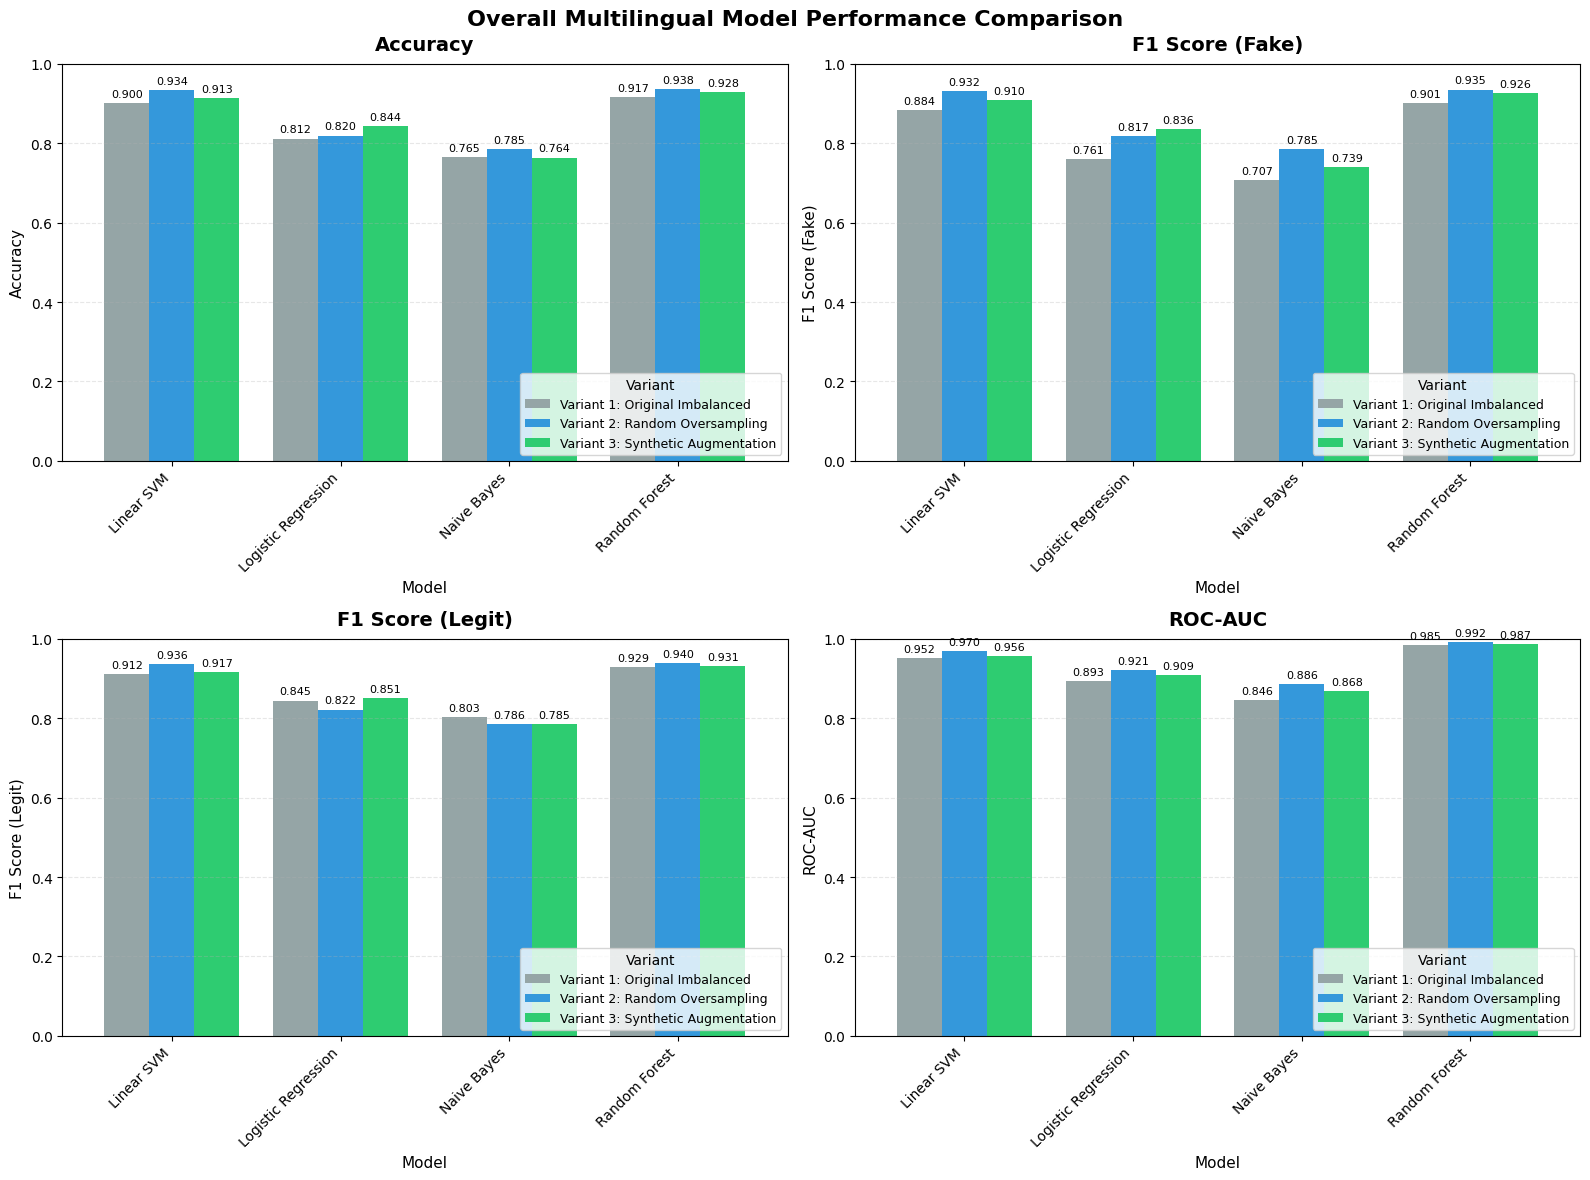

📊 Visualization complete: Overall model comparison across variants


In [36]:
# Visualize overall model performance across variants
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Overall Multilingual Model Performance Comparison', fontsize=16, fontweight='bold')

overall_results = results_df[results_df['language'] == 'Overall'].copy()

# Prepare data for plotting
metrics = ['accuracy', 'f1_fake', 'f1_legit', 'roc_auc']
metric_names = ['Accuracy', 'F1 Score (Fake)', 'F1 Score (Legit)', 'ROC-AUC']
colors = ['#2ecc71', '#e74c3c', '#3498db', '#f39c12']

for idx, (metric, metric_name) in enumerate(zip(metrics, metric_names)):
    ax = axes[idx // 2, idx % 2]
    
    # Create grouped bar chart
    pivot_data = overall_results.pivot(index='model', columns='variant', values=metric)
    pivot_data.plot(kind='bar', ax=ax, color=['#95a5a6', '#3498db', '#2ecc71'], width=0.8)
    
    ax.set_title(metric_name, fontsize=14, fontweight='bold', pad=10)
    ax.set_xlabel('Model', fontsize=11)
    ax.set_ylabel(metric_name, fontsize=11)
    ax.set_ylim([0, 1])
    ax.legend(title='Variant', fontsize=9, loc='lower right')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    
    # Add value labels on bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f', fontsize=8, padding=3)

plt.tight_layout()
plt.show()

print("📊 Visualization complete: Overall model comparison across variants")

### 12.2 Per-Language Performance Heatmaps

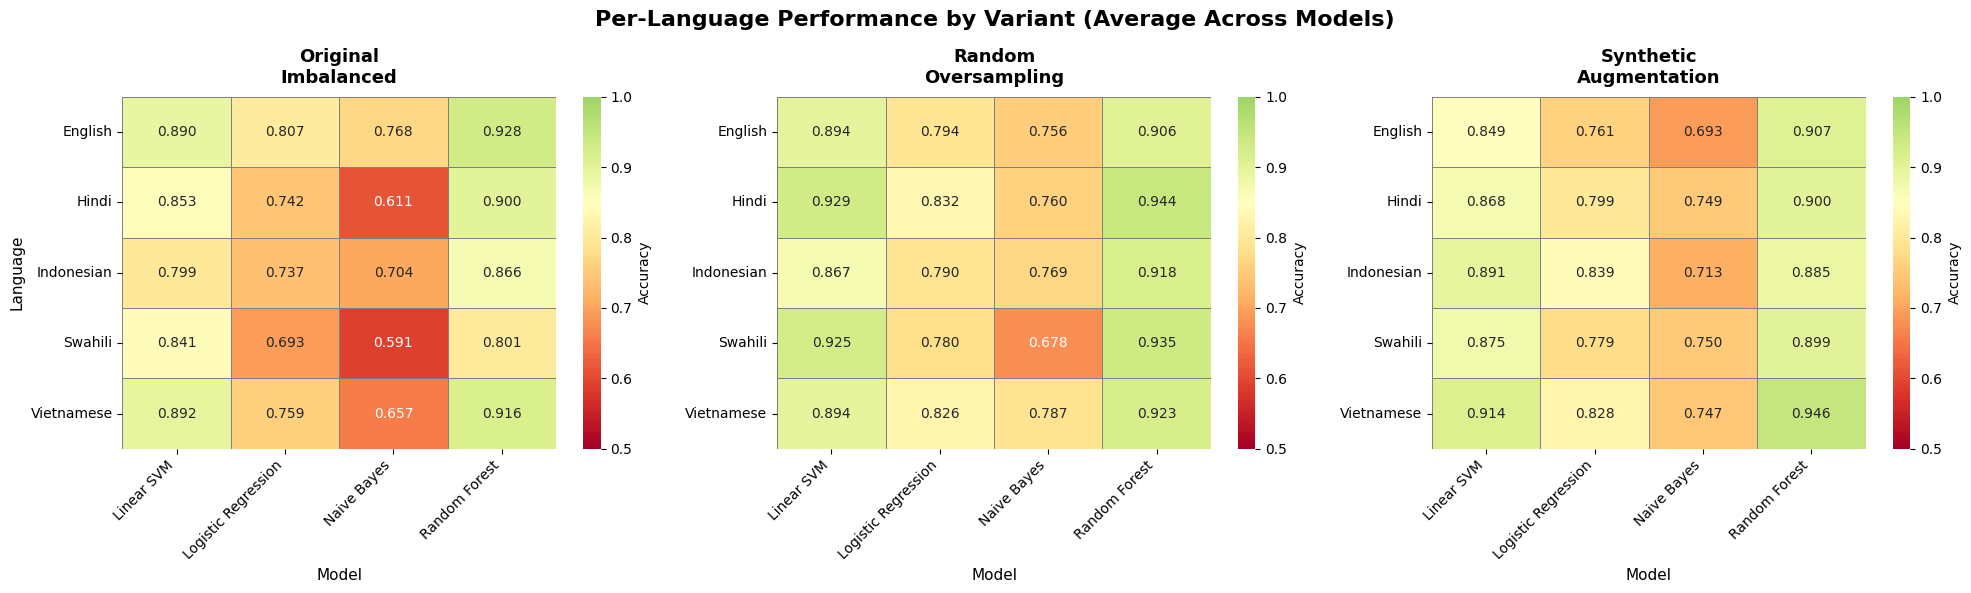

📊 Visualization complete: Per-language performance heatmaps


In [37]:
# Create heatmaps for per-language performance
perlang_results = results_df[results_df['language'] != 'Overall'].copy()

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Per-Language Performance by Variant (Average Across Models)', fontsize=16, fontweight='bold')

variants = ['Variant 1: Original Imbalanced', 'Variant 2: Random Oversampling', 'Variant 3: Synthetic Augmentation']
variant_labels = ['Original\nImbalanced', 'Random\nOversampling', 'Synthetic\nAugmentation']

for idx, (variant, variant_label) in enumerate(zip(variants, variant_labels)):
    ax = axes[idx]
    
    # Filter data for this variant
    variant_data = perlang_results[perlang_results['variant'] == variant]
    
    # Create pivot table: languages × models
    heatmap_data = variant_data.pivot_table(
        index='language',
        columns='model',
        values='accuracy',
        aggfunc='mean'
    )
    
    # Create heatmap
    sns.heatmap(
        heatmap_data,
        annot=True,
        fmt='.3f',
        cmap='RdYlGn',
        center=0.85,
        vmin=0.5,
        vmax=1.0,
        cbar_kws={'label': 'Accuracy'},
        ax=ax,
        linewidths=0.5,
        linecolor='gray'
    )
    
    ax.set_title(variant_label, fontsize=13, fontweight='bold', pad=10)
    ax.set_xlabel('Model', fontsize=11)
    ax.set_ylabel('Language' if idx == 0 else '', fontsize=11)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

plt.tight_layout()
plt.show()

print("📊 Visualization complete: Per-language performance heatmaps")

### 12.3 Language-Specific Performance by Variant

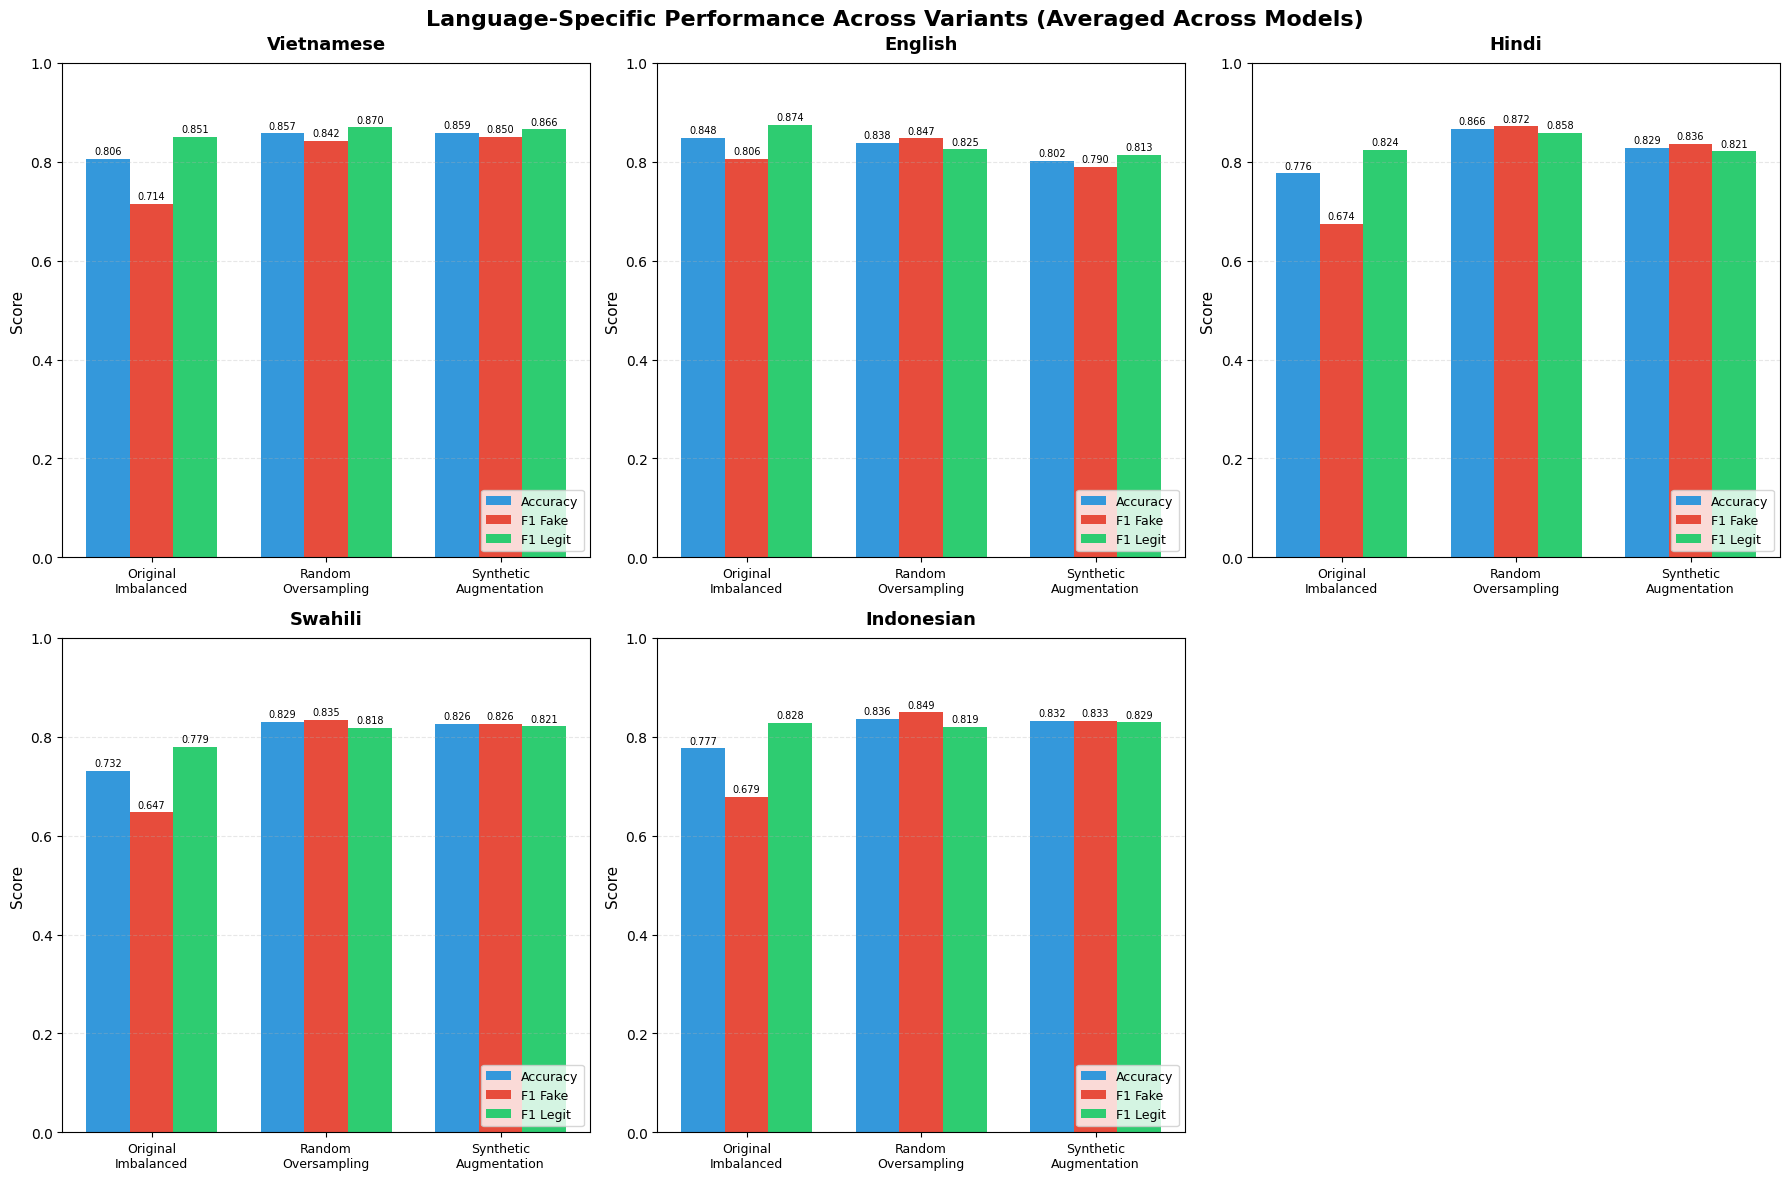

📊 Visualization complete: Language-specific performance across variants


In [38]:
# Compare performance across variants for each language
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Language-Specific Performance Across Variants (Averaged Across Models)', 
             fontsize=16, fontweight='bold')

languages = ['Vietnamese', 'English', 'Hindi', 'Swahili', 'Indonesian']
perlang_results = results_df[results_df['language'] != 'Overall'].copy()

for idx, language in enumerate(languages):
    ax = axes[idx // 3, idx % 3]
    
    # Filter data for this language
    lang_data = perlang_results[perlang_results['language'] == language]
    
    # Average across models for each variant
    variant_avg = lang_data.groupby('variant')[['accuracy', 'f1_fake', 'f1_legit']].mean()
    
    # Plot
    x = np.arange(len(variant_avg))
    width = 0.25
    
    ax.bar(x - width, variant_avg['accuracy'], width, label='Accuracy', color='#3498db')
    ax.bar(x, variant_avg['f1_fake'], width, label='F1 Fake', color='#e74c3c')
    ax.bar(x + width, variant_avg['f1_legit'], width, label='F1 Legit', color='#2ecc71')
    
    ax.set_title(f'{language}', fontsize=13, fontweight='bold', pad=10)
    ax.set_ylabel('Score', fontsize=11)
    ax.set_ylim([0, 1])
    ax.set_xticks(x)
    ax.set_xticklabels(['Original\nImbalanced', 'Random\nOversampling', 'Synthetic\nAugmentation'], 
                       fontsize=9)
    ax.legend(fontsize=9, loc='lower right')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add value labels
    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f', fontsize=7, padding=2)

# Hide the 6th subplot (we only have 5 languages)
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

print("📊 Visualization complete: Language-specific performance across variants")

### 12.4 Overall vs Per-Language Comparison

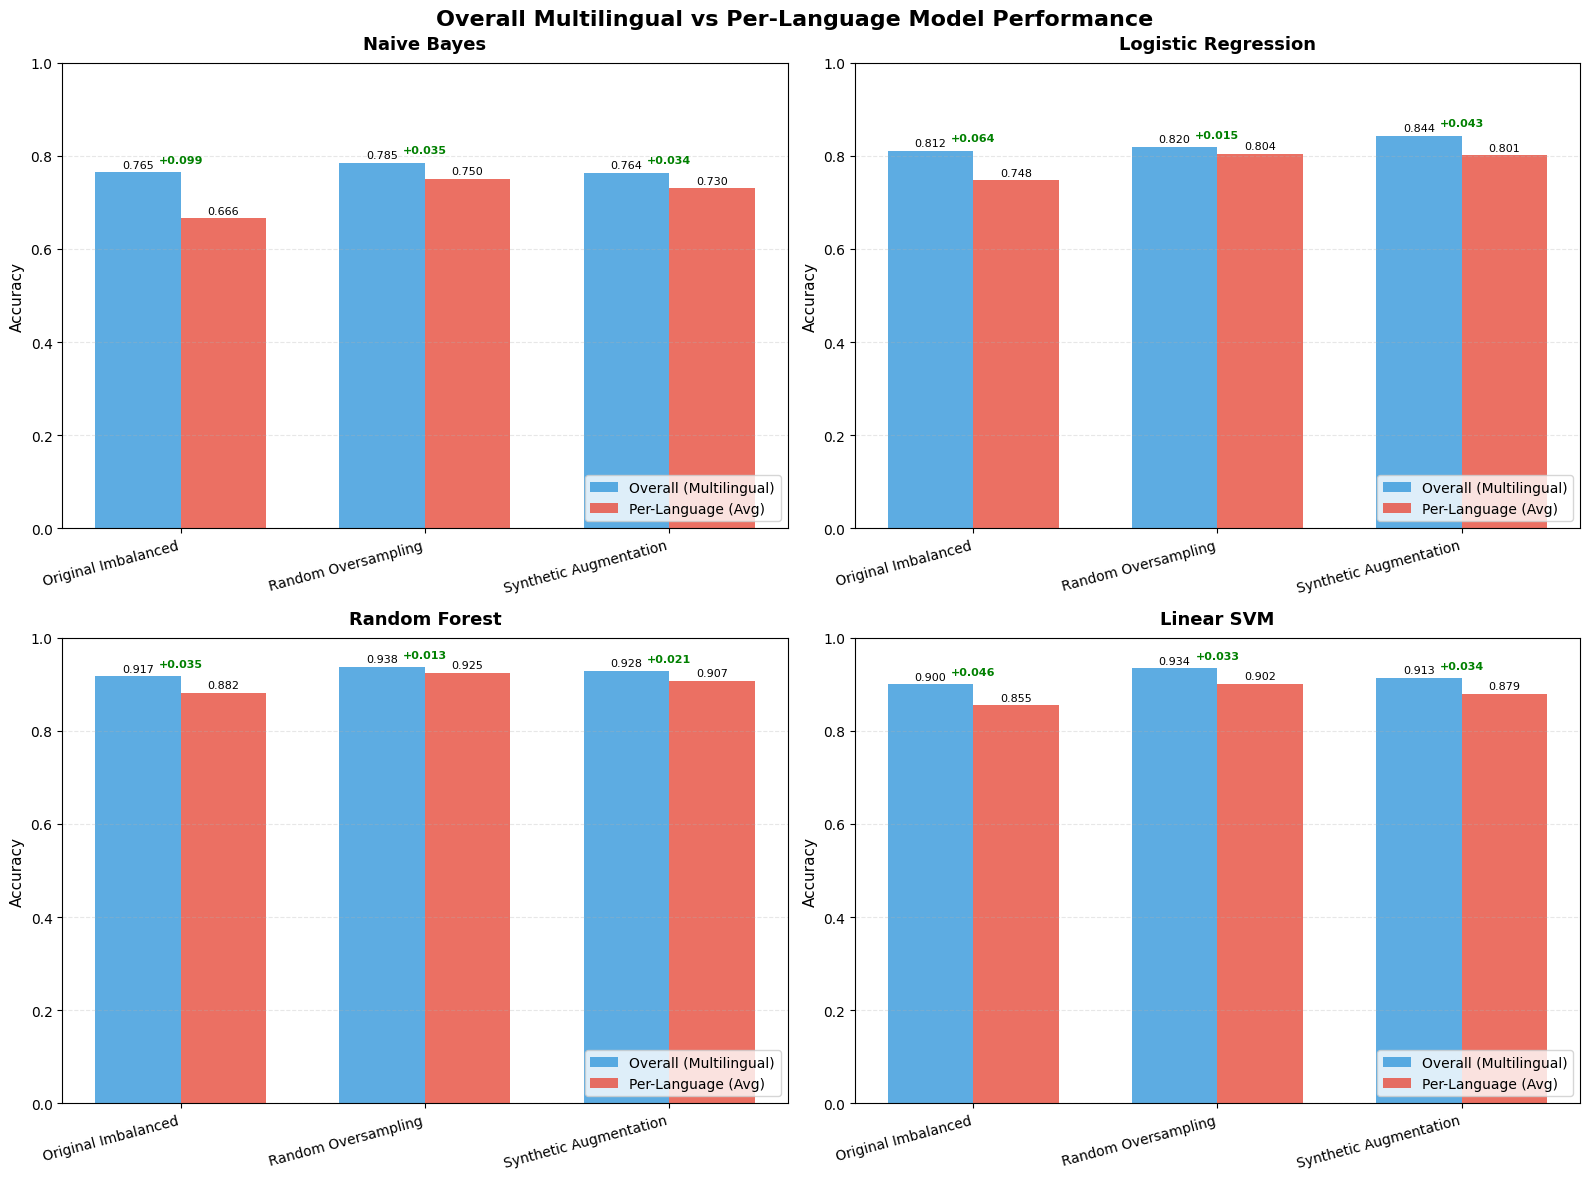

📊 Visualization complete: Overall vs per-language comparison by model and variant


In [39]:
# Visualize overall vs per-language performance
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Overall Multilingual vs Per-Language Model Performance', 
             fontsize=16, fontweight='bold')

overall_results = results_df[results_df['language'] == 'Overall'].copy()
perlang_results = results_df[results_df['language'] != 'Overall'].copy()

models = ['Naive Bayes', 'Logistic Regression', 'Random Forest', 'Linear SVM']
variants = ['Variant 1: Original Imbalanced', 'Variant 2: Random Oversampling', 'Variant 3: Synthetic Augmentation']

# For each model
for idx, model in enumerate(models):
    ax = axes[idx // 2, idx % 2]
    
    # Prepare data
    overall_data = []
    perlang_avg_data = []
    variant_labels = []
    
    for variant in variants:
        # Overall performance
        overall_row = overall_results[
            (overall_results['model'] == model) & 
            (overall_results['variant'] == variant)
        ]
        
        # Per-language average
        perlang_rows = perlang_results[
            (perlang_results['model'] == model) & 
            (perlang_results['variant'] == variant)
        ]
        
        if len(overall_row) > 0 and len(perlang_rows) > 0:
            overall_data.append(overall_row['accuracy'].values[0])
            perlang_avg_data.append(perlang_rows['accuracy'].mean())
            variant_labels.append(variant.split(':')[1].strip())
    
    # Plot
    x = np.arange(len(variant_labels))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, overall_data, width, label='Overall (Multilingual)', 
                   color='#3498db', alpha=0.8)
    bars2 = ax.bar(x + width/2, perlang_avg_data, width, label='Per-Language (Avg)', 
                   color='#e74c3c', alpha=0.8)
    
    ax.set_title(model, fontsize=13, fontweight='bold', pad=10)
    ax.set_ylabel('Accuracy', fontsize=11)
    ax.set_ylim([0, 1])
    ax.set_xticks(x)
    ax.set_xticklabels(variant_labels, rotation=15, ha='right', fontsize=10)
    ax.legend(fontsize=10, loc='lower right')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add value labels
    ax.bar_label(bars1, fmt='%.3f', fontsize=8, padding=2)
    ax.bar_label(bars2, fmt='%.3f', fontsize=8, padding=2)
    
    # Add difference indicators
    for i, (overall, perlang) in enumerate(zip(overall_data, perlang_avg_data)):
        diff = overall - perlang
        color = 'green' if diff > 0 else 'red'
        ax.text(i, max(overall, perlang) + 0.02, f'{diff:+.3f}', 
               ha='center', fontsize=8, color=color, fontweight='bold')

plt.tight_layout()
plt.show()

print("📊 Visualization complete: Overall vs per-language comparison by model and variant")

### 12.5 Best Model per Language

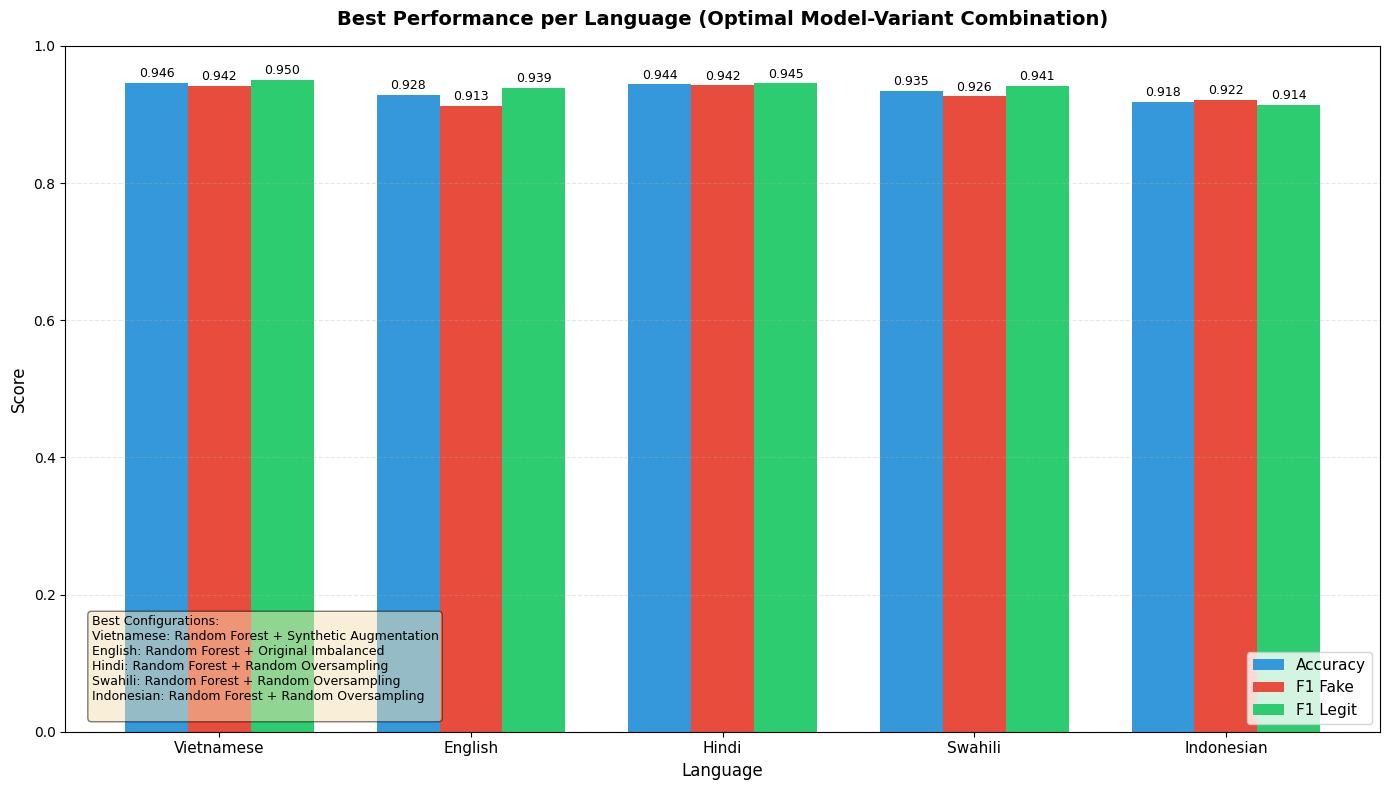

🏆 BEST PERFORMING MODEL-VARIANT COMBINATION PER LANGUAGE
  Language         Model                Variant  Accuracy  F1_Fake  F1_Legit
Vietnamese Random Forest Synthetic Augmentation  0.946237 0.941860  0.950000
   English Random Forest    Original Imbalanced  0.928177 0.912752  0.938967
     Hindi Random Forest    Random Oversampling  0.943878 0.942408  0.945274
   Swahili Random Forest    Random Oversampling  0.934579 0.926316  0.941176
Indonesian Random Forest    Random Oversampling  0.917949 0.921569  0.913978


In [40]:
# Identify and visualize best performing model-variant combination per language
perlang_results = results_df[results_df['language'] != 'Overall'].copy()

fig, ax = plt.subplots(figsize=(14, 8))

languages = ['Vietnamese', 'English', 'Hindi', 'Swahili', 'Indonesian']
best_results = []

for language in languages:
    lang_data = perlang_results[perlang_results['language'] == language]
    
    # Find best performing combination
    best_idx = lang_data['accuracy'].idxmax()
    best = lang_data.loc[best_idx]
    
    best_results.append({
        'Language': language,
        'Model': best['model'],
        'Variant': best['variant'].split(':')[1].strip(),
        'Accuracy': best['accuracy'],
        'F1_Fake': best['f1_fake'],
        'F1_Legit': best['f1_legit']
    })

best_df = pd.DataFrame(best_results)

# Create grouped bar chart
x = np.arange(len(languages))
width = 0.25

bars1 = ax.bar(x - width, best_df['Accuracy'], width, label='Accuracy', color='#3498db')
bars2 = ax.bar(x, best_df['F1_Fake'], width, label='F1 Fake', color='#e74c3c')
bars3 = ax.bar(x + width, best_df['F1_Legit'], width, label='F1 Legit', color='#2ecc71')

ax.set_title('Best Performance per Language (Optimal Model-Variant Combination)', 
            fontsize=14, fontweight='bold', pad=15)
ax.set_ylabel('Score', fontsize=12)
ax.set_xlabel('Language', fontsize=12)
ax.set_ylim([0, 1])
ax.set_xticks(x)
ax.set_xticklabels(languages, fontsize=11)
ax.legend(fontsize=11, loc='lower right')
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels
ax.bar_label(bars1, fmt='%.3f', fontsize=9, padding=2)
ax.bar_label(bars2, fmt='%.3f', fontsize=9, padding=2)
ax.bar_label(bars3, fmt='%.3f', fontsize=9, padding=2)

# Add model and variant info as text below
info_text = "Best Configurations:\n"
for _, row in best_df.iterrows():
    info_text += f"{row['Language']}: {row['Model']} + {row['Variant']}\n"

ax.text(0.02, 0.02, info_text, transform=ax.transAxes, fontsize=9,
        verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

# Print summary table
print("="*80)
print("🏆 BEST PERFORMING MODEL-VARIANT COMBINATION PER LANGUAGE")
print("="*80)
print(best_df.to_string(index=False))
print("="*80)

## 13. Key Findings and Export Results

In [41]:
# Summarize key findings
print("="*80)
print("🔍 KEY FINDINGS - MULTILINGUAL CLASSIFICATION COMPARISON")
print("="*80)

overall_results = results_df[results_df['language'] == 'Overall'].copy()
perlang_results = results_df[results_df['language'] != 'Overall'].copy()

# Finding 1: Best overall model
print("\n1️⃣  BEST OVERALL MULTILINGUAL MODEL:")
print("-" * 80)
best_overall = overall_results.loc[overall_results['accuracy'].idxmax()]
print(f"   Model: {best_overall['model']}")
print(f"   Variant: {best_overall['variant']}")
print(f"   Accuracy: {best_overall['accuracy']:.4f}")
print(f"   F1 Fake: {best_overall['f1_fake']:.4f}")
print(f"   F1 Legit: {best_overall['f1_legit']:.4f}")
print(f"   ROC-AUC: {best_overall['roc_auc']:.4f}")

# Finding 2: Variant effectiveness (overall)
print("\n2️⃣  VARIANT EFFECTIVENESS (Overall Models):")
print("-" * 80)
variant_avg = overall_results.groupby('variant')[['accuracy', 'f1_fake']].mean().sort_values('accuracy', ascending=False)
for variant, row in variant_avg.iterrows():
    print(f"   {variant}")
    print(f"      Avg Accuracy: {row['accuracy']:.4f}")
    print(f"      Avg F1 Fake:  {row['f1_fake']:.4f}")

# Finding 3: Language difficulty ranking
print("\n3️⃣  LANGUAGE DIFFICULTY RANKING (Easiest to Hardest):")
print("-" * 80)
lang_avg = perlang_results.groupby('language')['accuracy'].mean().sort_values(ascending=False)
for rank, (language, avg_acc) in enumerate(lang_avg.items(), 1):
    print(f"   {rank}. {language:12s}: {avg_acc:.4f} avg accuracy")

# Finding 4: Synthetic vs Random Oversampling
print("\n4️⃣  SYNTHETIC AUGMENTATION vs RANDOM OVERSAMPLING:")
print("-" * 80)
synthetic_results = overall_results[overall_results['variant'] == 'Variant 3: Synthetic Augmentation']
random_results = overall_results[overall_results['variant'] == 'Variant 2: Random Oversampling']

synthetic_avg = synthetic_results['accuracy'].mean()
random_avg = random_results['accuracy'].mean()
diff = synthetic_avg - random_avg

print(f"   Synthetic Augmentation avg accuracy: {synthetic_avg:.4f}")
print(f"   Random Oversampling avg accuracy:    {random_avg:.4f}")
print(f"   Difference:                          {diff:+.4f}")
if diff > 0:
    print(f"   → Synthetic augmentation performs BETTER by {abs(diff):.2%}")
elif diff < 0:
    print(f"   → Random oversampling performs BETTER by {abs(diff):.2%}")
else:
    print(f"   → Both methods perform EQUALLY")

# Finding 5: Overall vs Per-Language
print("\n5️⃣  OVERALL vs PER-LANGUAGE MODEL PERFORMANCE:")
print("-" * 80)
overall_avg = overall_results['accuracy'].mean()
perlang_avg = perlang_results['accuracy'].mean()
diff = overall_avg - perlang_avg

print(f"   Overall multilingual models avg:  {overall_avg:.4f}")
print(f"   Per-language models avg:          {perlang_avg:.4f}")
print(f"   Difference:                       {diff:+.4f}")
if diff > 0:
    print(f"   → Overall multilingual models perform BETTER by {abs(diff):.2%}")
else:
    print(f"   → Per-language models perform BETTER by {abs(diff):.2%}")

# Finding 6: Best per-language configurations
print("\n6️⃣  BEST CONFIGURATION PER LANGUAGE:")
print("-" * 80)
for language in ['Vietnamese', 'English', 'Hindi', 'Swahili', 'Indonesian']:
    lang_data = perlang_results[perlang_results['language'] == language]
    best = lang_data.loc[lang_data['accuracy'].idxmax()]
    print(f"   {language:12s}: {best['model']:20s} + {best['variant'].split(':')[1].strip():20s} → {best['accuracy']:.4f}")

# Finding 7: Model ranking
print("\n7️⃣  MODEL RANKING (Overall Average):")
print("-" * 80)
model_avg = results_df.groupby('model')['accuracy'].mean().sort_values(ascending=False)
for rank, (model, avg_acc) in enumerate(model_avg.items(), 1):
    print(f"   {rank}. {model:20s}: {avg_acc:.4f}")

print("\n" + "="*80)
print("✅ Key findings summary complete")
print("="*80)

🔍 KEY FINDINGS - MULTILINGUAL CLASSIFICATION COMPARISON

1️⃣  BEST OVERALL MULTILINGUAL MODEL:
--------------------------------------------------------------------------------
   Model: Random Forest
   Variant: Variant 2: Random Oversampling
   Accuracy: 0.9375
   F1 Fake: 0.9353
   F1 Legit: 0.9396
   ROC-AUC: 0.9922

2️⃣  VARIANT EFFECTIVENESS (Overall Models):
--------------------------------------------------------------------------------
   Variant 2: Random Oversampling
      Avg Accuracy: 0.8692
      Avg F1 Fake:  0.8674
   Variant 3: Synthetic Augmentation
      Avg Accuracy: 0.8624
      Avg F1 Fake:  0.8528
   Variant 1: Original Imbalanced
      Avg Accuracy: 0.8484
      Avg F1 Fake:  0.8131

3️⃣  LANGUAGE DIFFICULTY RANKING (Easiest to Hardest):
--------------------------------------------------------------------------------
   1. Vietnamese  : 0.8407 avg accuracy
   2. English     : 0.8293 avg accuracy
   3. Hindi       : 0.8237 avg accuracy
   4. Indonesian  : 0.8148 a

In [42]:
# Export results to CSV
output_dir = Path('/home/mateja/Documents/IJS/current/Fairer_Models/data/classification_results')
output_dir.mkdir(parents=True, exist_ok=True)

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# Export full results
results_file = output_dir / f'multilingual_tfidf_results_{timestamp}.csv'
results_df.to_csv(results_file, index=False)
print(f"✅ Full results exported to: {results_file}")

# Export summary statistics
summary_data = {
    'overall_best_model': [best_overall['model']],
    'overall_best_variant': [best_overall['variant']],
    'overall_best_accuracy': [best_overall['accuracy']],
    'overall_best_f1_fake': [best_overall['f1_fake']],
    'synthetic_avg_accuracy': [synthetic_avg],
    'random_oversampling_avg_accuracy': [random_avg],
    'overall_multilingual_avg': [overall_avg],
    'per_language_avg': [perlang_avg],
    'total_experiments': [len(results_df)],
    'timestamp': [timestamp]
}

summary_df = pd.DataFrame(summary_data)
summary_file = output_dir / f'multilingual_tfidf_summary_{timestamp}.csv'
summary_df.to_csv(summary_file, index=False)
print(f"✅ Summary statistics exported to: {summary_file}")

print(f"\n📁 Results saved to: {output_dir}")
print("="*80)

✅ Full results exported to: /home/mateja/Documents/IJS/current/Fairer_Models/data/classification_results/multilingual_tfidf_results_20251207_185147.csv
✅ Summary statistics exported to: /home/mateja/Documents/IJS/current/Fairer_Models/data/classification_results/multilingual_tfidf_summary_20251207_185147.csv

📁 Results saved to: /home/mateja/Documents/IJS/current/Fairer_Models/data/classification_results


## 14. Random Forest Results - All Languages and Variants

In [43]:
# Filter Random Forest results only
print("="*80)
print("🌲 RANDOM FOREST RESULTS - ALL LANGUAGES & VARIANTS")
print("="*80)

rf_results = results_df[results_df['model'] == 'Random Forest'].copy()

print(f"\n📊 Total Random Forest experiments: {len(rf_results)}")
print(f"   Overall: {len(rf_results[rf_results['language'] == 'Overall'])}")
print(f"   Per-language: {len(rf_results[rf_results['language'] != 'Overall'])}")

# Create comprehensive table
print("\n" + "="*80)
print("📋 COMPLETE RANDOM FOREST RESULTS")
print("="*80)

# Sort by variant then language
rf_results_sorted = rf_results.sort_values(['variant', 'language'])

# Display with formatted columns
display_df = rf_results_sorted[[
    'language', 'variant', 'accuracy', 'f1_fake', 'f1_legit', 
    'precision_fake', 'recall_fake', 'roc_auc', 'train_size', 'test_size'
]].copy()

# Rename variant for readability
display_df['variant'] = display_df['variant'].str.replace('Variant 1: ', 'V1: ')
display_df['variant'] = display_df['variant'].str.replace('Variant 2: ', 'V2: ')
display_df['variant'] = display_df['variant'].str.replace('Variant 3: ', 'V3: ')

print("\n" + display_df.to_string(index=False))

print("\n" + "="*80)

🌲 RANDOM FOREST RESULTS - ALL LANGUAGES & VARIANTS

📊 Total Random Forest experiments: 18
   Overall: 3
   Per-language: 15

📋 COMPLETE RANDOM FOREST RESULTS

  language                    variant  accuracy  f1_fake  f1_legit  precision_fake  recall_fake  roc_auc  train_size  test_size
   English    V1: Original Imbalanced  0.928177 0.912752  0.938967        0.971429     0.860759 0.986721         711        181
     Hindi    V1: Original Imbalanced  0.900000 0.881988  0.913242        1.000000     0.788889 0.981667         700        190
Indonesian    V1: Original Imbalanced  0.865922 0.812500  0.895652        0.896552     0.742857 0.955898         699        179
   Overall    V1: Original Imbalanced  0.917040 0.900804  0.928709        0.960000     0.848485 0.984670        3564        892
   Swahili    V1: Original Imbalanced  0.801136 0.777070  0.820513        0.835616     0.726190 0.940282         708        176
Vietnamese    V1: Original Imbalanced  0.915663 0.893939  0.930000       

In [44]:
# Create pivot tables for easier comparison
print("="*80)
print("📊 RANDOM FOREST - ACCURACY BY LANGUAGE & VARIANT")
print("="*80)

rf_pivot_accuracy = rf_results.pivot_table(
    index='language',
    columns='variant',
    values='accuracy',
    aggfunc='mean'
)

# Reorder columns
variant_order = [
    'Variant 1: Original Imbalanced',
    'Variant 2: Random Oversampling', 
    'Variant 3: Synthetic Augmentation'
]
rf_pivot_accuracy = rf_pivot_accuracy[variant_order]

# Rename columns for display
rf_pivot_accuracy.columns = ['Original\nImbalanced', 'Random\nOversampling', 'Synthetic\nAugmentation']

print("\n" + rf_pivot_accuracy.round(4).to_string())

# F1 Score (Fake Detection)
print("\n" + "="*80)
print("📊 RANDOM FOREST - F1 SCORE (FAKE DETECTION) BY LANGUAGE & VARIANT")
print("="*80)

rf_pivot_f1 = rf_results.pivot_table(
    index='language',
    columns='variant',
    values='f1_fake',
    aggfunc='mean'
)

rf_pivot_f1 = rf_pivot_f1[variant_order]
rf_pivot_f1.columns = ['Original\nImbalanced', 'Random\nOversampling', 'Synthetic\nAugmentation']

print("\n" + rf_pivot_f1.round(4).to_string())

print("\n" + "="*80)

📊 RANDOM FOREST - ACCURACY BY LANGUAGE & VARIANT

            Original\nImbalanced  Random\nOversampling  Synthetic\nAugmentation
language                                                                       
English                   0.9282                0.9056                   0.9073
Hindi                     0.9000                0.9439                   0.8995
Indonesian                0.8659                0.9179                   0.8851
Overall                   0.9170                0.9375                   0.9284
Swahili                   0.8011                0.9346                   0.8990
Vietnamese                0.9157                0.9227                   0.9462

📊 RANDOM FOREST - F1 SCORE (FAKE DETECTION) BY LANGUAGE & VARIANT

            Original\nImbalanced  Random\nOversampling  Synthetic\nAugmentation
language                                                                       
English                   0.9128                0.9050                   0.9064
Hi

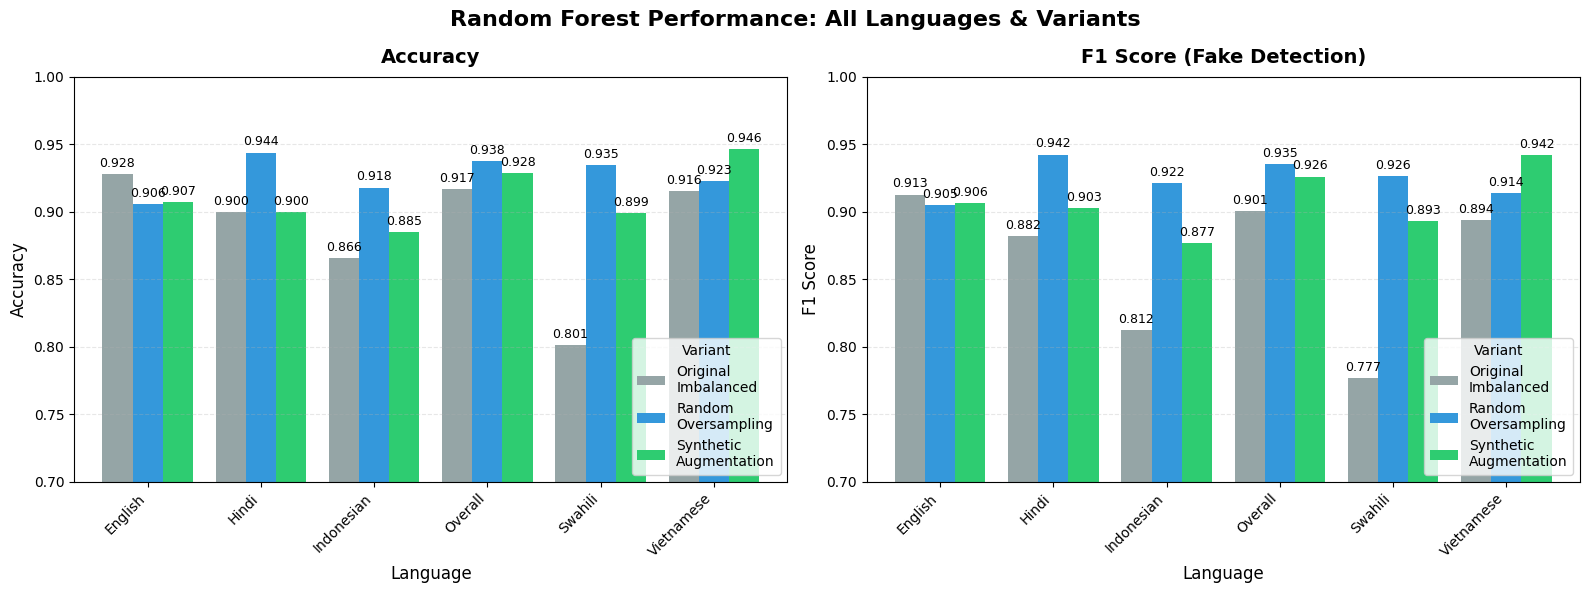

📊 Random Forest visualization complete


In [45]:
# Visualize Random Forest results
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Random Forest Performance: All Languages & Variants', fontsize=16, fontweight='bold')

# Plot 1: Accuracy
ax1 = axes[0]
rf_pivot_accuracy.plot(kind='bar', ax=ax1, color=['#95a5a6', '#3498db', '#2ecc71'], width=0.8)
ax1.set_title('Accuracy', fontsize=14, fontweight='bold', pad=10)
ax1.set_xlabel('Language', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_ylim([0.7, 1.0])
ax1.legend(title='Variant', fontsize=10, loc='lower right')
ax1.grid(axis='y', alpha=0.3, linestyle='--')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

# Add value labels
for container in ax1.containers:
    ax1.bar_label(container, fmt='%.3f', fontsize=9, padding=3)

# Plot 2: F1 Score (Fake Detection)
ax2 = axes[1]
rf_pivot_f1.plot(kind='bar', ax=ax2, color=['#95a5a6', '#3498db', '#2ecc71'], width=0.8)
ax2.set_title('F1 Score (Fake Detection)', fontsize=14, fontweight='bold', pad=10)
ax2.set_xlabel('Language', fontsize=12)
ax2.set_ylabel('F1 Score', fontsize=12)
ax2.set_ylim([0.7, 1.0])
ax2.legend(title='Variant', fontsize=10, loc='lower right')
ax2.grid(axis='y', alpha=0.3, linestyle='--')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')

# Add value labels
for container in ax2.containers:
    ax2.bar_label(container, fmt='%.3f', fontsize=9, padding=3)

plt.tight_layout()
plt.show()

print("📊 Random Forest visualization complete")

In [46]:
# Key insights for Random Forest
print("="*80)
print("🔍 KEY INSIGHTS - RANDOM FOREST PERFORMANCE")
print("="*80)

rf_overall = rf_results[rf_results['language'] == 'Overall']
rf_perlang = rf_results[rf_results['language'] != 'Overall']

print("\n1️⃣  OVERALL (MULTILINGUAL) PERFORMANCE:")
print("-" * 80)
for _, row in rf_overall.iterrows():
    variant_short = row['variant'].split(':')[1].strip()
    print(f"   {variant_short:25s}: Acc={row['accuracy']:.4f}, F1={row['f1_fake']:.4f}, ROC-AUC={row['roc_auc']:.4f}")

print("\n2️⃣  BEST PERFORMING LANGUAGE PER VARIANT:")
print("-" * 80)
for variant in ['Variant 1: Original Imbalanced', 'Variant 2: Random Oversampling', 'Variant 3: Synthetic Augmentation']:
    variant_data = rf_perlang[rf_perlang['variant'] == variant]
    best = variant_data.loc[variant_data['accuracy'].idxmax()]
    variant_short = variant.split(':')[1].strip()
    print(f"   {variant_short:25s}: {best['language']:12s} (Acc={best['accuracy']:.4f}, F1={best['f1_fake']:.4f})")

print("\n3️⃣  WORST PERFORMING LANGUAGE PER VARIANT:")
print("-" * 80)
for variant in ['Variant 1: Original Imbalanced', 'Variant 2: Random Oversampling', 'Variant 3: Synthetic Augmentation']:
    variant_data = rf_perlang[rf_perlang['variant'] == variant]
    worst = variant_data.loc[variant_data['accuracy'].idxmin()]
    variant_short = variant.split(':')[1].strip()
    print(f"   {variant_short:25s}: {worst['language']:12s} (Acc={worst['accuracy']:.4f}, F1={worst['f1_fake']:.4f})")

print("\n4️⃣  IMPROVEMENT FROM ORIGINAL TO RANDOM OVERSAMPLING:")
print("-" * 80)
languages_list = ['Overall', 'Vietnamese', 'English', 'Hindi', 'Swahili', 'Indonesian']
for lang in languages_list:
    original = rf_results[(rf_results['language'] == lang) & (rf_results['variant'] == 'Variant 1: Original Imbalanced')]
    random_os = rf_results[(rf_results['language'] == lang) & (rf_results['variant'] == 'Variant 2: Random Oversampling')]
    
    if len(original) > 0 and len(random_os) > 0:
        orig_acc = original['accuracy'].values[0]
        rand_acc = random_os['accuracy'].values[0]
        improvement = rand_acc - orig_acc
        print(f"   {lang:12s}: {orig_acc:.4f} → {rand_acc:.4f} ({improvement:+.4f}, {improvement/orig_acc*100:+.1f}%)")

print("\n5️⃣  IMPROVEMENT FROM ORIGINAL TO SYNTHETIC AUGMENTATION:")
print("-" * 80)
for lang in languages_list:
    original = rf_results[(rf_results['language'] == lang) & (rf_results['variant'] == 'Variant 1: Original Imbalanced')]
    synthetic = rf_results[(rf_results['language'] == lang) & (rf_results['variant'] == 'Variant 3: Synthetic Augmentation')]
    
    if len(original) > 0 and len(synthetic) > 0:
        orig_acc = original['accuracy'].values[0]
        synth_acc = synthetic['accuracy'].values[0]
        improvement = synth_acc - orig_acc
        print(f"   {lang:12s}: {orig_acc:.4f} → {synth_acc:.4f} ({improvement:+.4f}, {improvement/orig_acc*100:+.1f}%)")

print("\n6️⃣  SYNTHETIC vs RANDOM OVERSAMPLING (Which is Better?):")
print("-" * 80)
for lang in languages_list:
    random_os = rf_results[(rf_results['language'] == lang) & (rf_results['variant'] == 'Variant 2: Random Oversampling')]
    synthetic = rf_results[(rf_results['language'] == lang) & (rf_results['variant'] == 'Variant 3: Synthetic Augmentation')]
    
    if len(random_os) > 0 and len(synthetic) > 0:
        rand_acc = random_os['accuracy'].values[0]
        synth_acc = synthetic['accuracy'].values[0]
        diff = synth_acc - rand_acc
        winner = "Synthetic" if diff > 0 else "Random OS" if diff < 0 else "TIE"
        print(f"   {lang:12s}: Random={rand_acc:.4f} vs Synthetic={synth_acc:.4f} ({diff:+.4f}) → {winner}")

print("\n" + "="*80)

🔍 KEY INSIGHTS - RANDOM FOREST PERFORMANCE

1️⃣  OVERALL (MULTILINGUAL) PERFORMANCE:
--------------------------------------------------------------------------------
   Original Imbalanced      : Acc=0.9170, F1=0.9008, ROC-AUC=0.9847
   Random Oversampling      : Acc=0.9375, F1=0.9353, ROC-AUC=0.9922
   Synthetic Augmentation   : Acc=0.9284, F1=0.9261, ROC-AUC=0.9872

2️⃣  BEST PERFORMING LANGUAGE PER VARIANT:
--------------------------------------------------------------------------------
   Original Imbalanced      : English      (Acc=0.9282, F1=0.9128)
   Random Oversampling      : Hindi        (Acc=0.9439, F1=0.9424)
   Synthetic Augmentation   : Vietnamese   (Acc=0.9462, F1=0.9419)

3️⃣  WORST PERFORMING LANGUAGE PER VARIANT:
--------------------------------------------------------------------------------
   Original Imbalanced      : Swahili      (Acc=0.8011, F1=0.7771)
   Random Oversampling      : English      (Acc=0.9056, F1=0.9050)
   Synthetic Augmentation   : Indonesian   (